# L-Deep Neural Network Implementation

In this homework, you will develop, train, and test a generic fully connected L-Layer Neural Network. You will use your network as a binary classifier for faces and general images.

Many of the guardrails present in Homework #1 were removed. You will have more freedom on the implementation, but that will also increase the complexity of the homework. Make sure that you start early. Network training takes time and many trials.

**General Instructions**
1. All coding should be done in Python 3
2. Follow the instructions provided in each cell and complete each sub-task.
    1. Always vectorize your code when possible
    2. Create a Code and Markdown cells after each subtask to test and document your progress, respectively.
    3. Comment your code thoroughly
    4. For cells that explicitly require a "write-up," complete those portions on the provided Word template.
3. Export your notebook and Word file in PDF format. Make sure that your PDF contains all notebook output.
4. Submit the PDF files and your Jupyter Notebook.


**Homework parts:**
1. Load, pre-process, and split the dataset [Points: 20]
2. Build L-Layer Deep Neural Network Components [Points: 40]
3. Build a 2-Layer Neural Network [Points: 25]
4. Build an L-layer Neural Network [Points: 15]
5. Hyper-parameter exploration, results analysis, and self-test [Points: 20] [Optional for COSC424]

Recall that your will add custom code between the lines:\
/###############################\
/## YOUR CODE STARTS HERE\
\
/## YOUR CODE ENDS HERE\
/###############################\

In [1]:
### v1.0

## 0 - Packages, setup, and helper functions

In [2]:
import os
import time
import copy
import h5py
import glob
import scipy
import random
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from numpy.random import Generator, PCG64DXSM
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from scipy import ndimage

# Using PCG64 as random generator
# Place seed [optional] for troubleshooting
rng = Generator(PCG64DXSM(seed=21))

# matplotlib general set up
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# This is helper function I use when fine-tuning large networks or when the gradient descent iterations are more than needed.
# I use this after verifying proper data normalization and weight initialization. This removes activation output out of the
# domain of the cost and derivatives steps (e.g., log(0) and division by zero). You may not need this. If you use it, use it with caution.
def replace_out_domain(A):

    epsilon = np.finfo(np.float32).eps
    A[A==0] = epsilon
    A[A==1] = 1.0 - epsilon

    #return NaN safe A
    return A

## 1 - Load, pre-process, and split the Dataset [Points: 20]

You will be using a subset of the Caltech-101 dataset. For this binary classification problem, we will focus on the face and background sets.

The size of the images vary.

Instructions:
1. Download dataset from Canvas
2. Unzip and place data folder on your notebook root folder.
3. Identify the Faces and BACKGROUND_Google subfolders
4. Load the dataset to memory.
5. Pre-process the dataset.
6. Split the dataset in a 70/30 ratio: generate a training set with ~70% of the samples and a validation set with ~30% of the samples.
    1. Note that we are not generating a test set for this homework.
    2. Identify the face_id.csv file, which gives a unique ID to each face in the dataset. How is this file important when generating the training and validation sets?

### 1.0 Load dataset [DO NOT CHANGE]


In [3]:
# Load face and background images
def load_data(data_folder_path):

    # Array to save images and corresponding label
    back_imgs = []
    face_imgs = []
    face_ids = []

    # Load CSV file with face ids
    column_name = ['FILENAME', 'FACEID']
    face_image_id_table = pd.read_csv(os.path.join(data_folder_path, "face_id.csv"), names=column_name, header=None)

    # Load images
    # Faces
    for idx in face_image_id_table.index:
        path2img = os.path.join(data_folder_path, "Faces", face_image_id_table[column_name[0]][idx])
        im=Image.open(path2img)                     #load image
        face_imgs.append(ImageOps.grayscale(im))   #store grayscale image
        face_ids.append(face_image_id_table[column_name[1]][idx])

    # Background
    for filename in glob.glob(os.path.join(data_folder_path, 'BACKGROUND_Google', '*.jpg')):
        im=Image.open(filename)                     #load image
        back_imgs.append(ImageOps.grayscale(im))    #store grayscale image

    # Convert to face ids to numpy array
    face_ids = np.array(face_ids).reshape(len(face_ids), 1)

    # Return raw dataset
    return face_imgs, face_ids, back_imgs

In [4]:
from google.colab import drive  ##Upload data on Gdrive and using data drom google drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.0.0 Verify dataset is loading correctly

Add the path to the data folder below and run the cell.

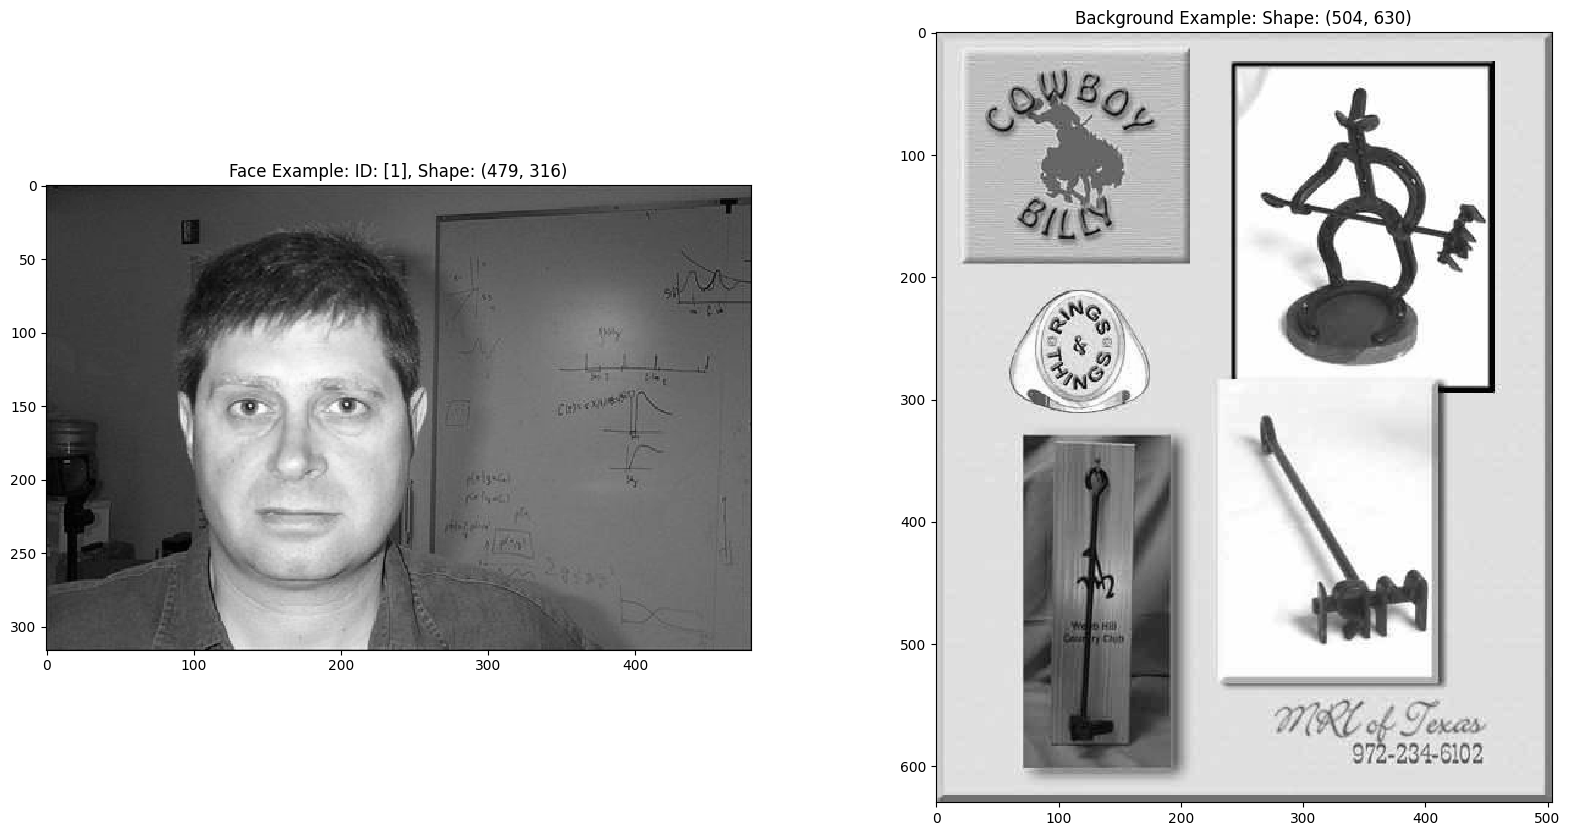

Dataset statistics:
Number of face images is 435
Number of face IDs is 435
Number of background images is 467


In [5]:

###############################
## YOUR CODE STARTS HERE
#Here, is the path of my gdrive data folder, where data is located
path_to_data_folder = "/content/drive/MyDrive/data"

## YOUR CODE ENDS HERE
###############################

# Make sure that image, loading the data
orig_face_imgs, face_ids, orig_back_imgs = load_data(path_to_data_folder)

# Example of face and background images
# Face and background index
face_index = 10
back_index = 30

##Example figures of the dataset

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(orig_face_imgs[face_index])
plt.title("Face Example: ID: " + str(face_ids[face_index]) + ", Shape: " + str(orig_face_imgs[face_index].size))
plt.subplot(1, 2, 2)
plt.imshow(orig_back_imgs[back_index])
plt.title("Background Example: Shape: " + str(orig_back_imgs[back_index].size))
plt.show()

# Print out size of dataset
print("Dataset statistics:")
print("Number of face images is " + str(len(orig_face_imgs)))
print("Number of face IDs is " + str(face_ids.shape[0]))
print("Number of background images is " + str(len(orig_back_imgs)))



### 1.1 Process dataset

In this task you will pre-process the dataset for ingestion by the model. You will build three functions that will perform the following steps:
1. Make images of same size (50, 50)
2. Normalize by $I = \frac{I - \min(I)}{(\max(I)-\min(I))}$
3. Flatten images to vectors for ingestion into our networks

In [6]:
def reshape_images(images, new_size):
    """
    Implements function that reshapes list of Pillow Images of size (n, p) to size (nn, pp).

    Arguments:
    images -- list of Pillow images of size (n,p)
    new_size -- tuple (nn, pp) with desired image size

    Returns:
    new_imgs -- list of reshaped images (nn, pp)
    """

    # list storing new images
    new_imgs = []


    ###############################
    ## YOUR CODE STARTS HERE
    #Here, I have used the .resize() function to resize the given image. Also, Image.ANTIALIAS is passed which ensures
    ## that the downsampling is done with a high-quality filter, helping to produce a smoother and visually appealing resized image.

    for img in images:
        new_img = img.resize(new_size, Image.ANTIALIAS)
        new_imgs.append(new_img)

    ## YOUR CODE ENDS HERE
    ###############################

    #return new images of same shape
    return new_imgs



def flatten_norm_imgs(images):
    """
    Implements function that converts 2-D images to 1-D floating point vectors and normalize the image to values between 0 and 1.
    This function should return a floating point numpy matrix of size (nx,m), where nx is the size of the images (i.e., nx =n*p)
    and m is the number of images.

    Arguments:
    images -- list of Pillow images of size (n,p) and pixel values between 0 and 255

    Returns:
    new_imgs -- (nx, m) matrix of Numpy floating point flatten images, where each image is in a column of new_img. The
    values of this matrix are between 0 and 1.
    """


    ###############################
    ## YOUR CODE STARTS HERE

    # Get the size of each image (assuming all images have the same size based on the above resized images)
    n, p = images[0].size

    # Flatten and normalize images
    new_imgs = np.zeros((n * p, len(images)))

    for i, img in enumerate(images):
        # Flatten the image to a 1D array and normalize pixel values to [0, 1] by dividing the image 255.0

        flat_normalized_img = np.array(img).flatten().astype(float) / 255.0
        new_imgs[:, i] = flat_normalized_img

    ## YOUR CODE ENDS HERE
    ###############################

    #return new images
    return new_imgs

### 1.1.1 Reshape, flatten, norm images
Use the functions build previously to reshape images to the same size and then, flatten and normalize the images to numpy vectors. This is for testing purposes. You will build a function below that will reuse all these functions

The size of first original face image is: (510, 337)
The size of second original face image is: (492, 325) 

The size of first original background image is: (168, 288)
The size of second original background image is: (168, 288) 

The size of first resized face image is: (64, 64)
The size of second resized face image is: (64, 64) 

The size of first resized back image is: (64, 64)
The size of second resized back image is: (64, 64) 



<ipython-input-6-094a2013ea19>:23: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  new_img = img.resize(new_size, Image.ANTIALIAS)


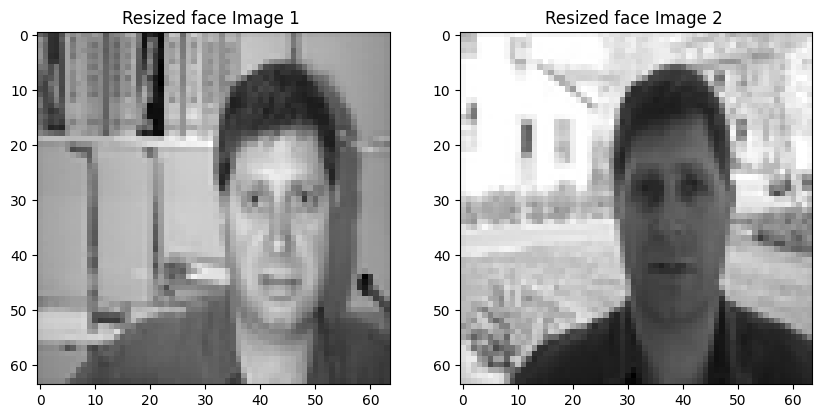

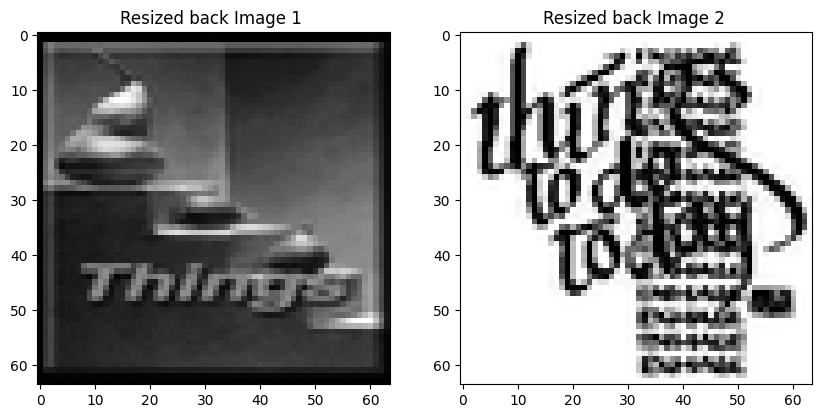

In [7]:
# Test the functions above here.
# Here, I am testing above load data to make sure that it is working.

I_AM_TESTING = True
if(I_AM_TESTING):

    ###############################
    ## YOUR CODE STARTS HERE

    # Load some example images such as two images of face and two images of background
    image_face_1 = orig_face_imgs[0]
    image_face_2 = orig_face_imgs[2]

    image_back_1 = orig_back_imgs[0]
    image_back_2 = orig_back_imgs[1]

    print("The size of first original face image is:", image_face_1.size)
    print("The size of second original face image is:", image_face_2.size, "\n")

    print("The size of first original background image is:", image_back_1.size)
    print("The size of second original background image is:", image_back_1.size, "\n")

    # Resize the face images to the size of 64 x 64
    resized_face_images = reshape_images([image_face_1, image_face_2], new_size=(64, 64))

    # Resize the back images to the size of 64 x 64
    resized_back_images = reshape_images([image_back_1, image_back_2], new_size=(64, 64))

    print("The size of first resized face image is:", resized_face_images[0].size)
    print("The size of second resized face image is:", resized_face_images[1].size, "\n")

    print("The size of first resized back image is:", resized_back_images[0].size)
    print("The size of second resized back image is:", resized_back_images[1].size, "\n")

    # Display the resized face images
    plt.figure(figsize=(10,10))
    plt.subplot(1, 2, 1)
    plt.imshow(resized_face_images[0])
    plt.title("Resized face Image 1 ")
    plt.subplot(1, 2, 2)
    plt.imshow(resized_face_images[1])
    plt.title("Resized face Image 2 ")
    plt.show()

    # Display the resized background images
    plt.figure(figsize=(10,10))
    plt.subplot(1, 2, 1)
    plt.imshow(resized_back_images[0])
    plt.title("Resized back Image 1 ")
    plt.subplot(1, 2, 2)
    plt.imshow(resized_back_images[1])
    plt.title("Resized back Image 2 ")
    plt.show()

    #Now, testing the flatten and normalized function to make sure that it is working fine.
    # Flatten and normalize the resized images of face
    flat_norm_face_images = flatten_norm_imgs(resized_face_images)

    # Flatten and normalize the resized images of background
    flat_norm_back_images = flatten_norm_imgs(resized_back_images)

    ##Here, I am resizing, flattening and normalizing whole data.
    #resize, flatten and normalize all face and background images
    resized_face_images = reshape_images(orig_face_imgs, new_size=(64, 64))
    resized_back_images = reshape_images(orig_back_imgs, new_size=(64, 64))

    flat_norm_face_images = flatten_norm_imgs(resized_face_images)
    flat_norm_back_images = flatten_norm_imgs(resized_back_images)

    ## YOUR CODE ENDS HERE
    ###############################


### 1.2 Process dataset for training and testing

For this task, you will process the original Pillow images into Numpy matrices that are ready for model training and testing. This includes:
1. Resize images
2. Flatten images
3. Normalize images
4. Split the dataset in a training and validation set.
    1. Split the dataset according to the best practices discussed in class. E.g., avoid data leakage.
5. Generate the correct labels (i.e., ground truth) for your images.
6. Analyze the final data sets

In [8]:
def split_faces(face_images, face_ids, training_ratio):
    '''
    This function receives a matrix (nx, m) of facial images and a vector of length m of facial IDs.
    The image in column k of face_images corresponds to the face ID in element k of face_ids.
    It splits this joint dataset in a training and validation sets.

    Arguments:
    face_images -- matrix (nx, m) with the facial images.
    face_ids -- Unique identifiers for the subjects images in the columns of face_images. If element k
    and k+1 in face_ids has the same ID, it means that the images in column k and k+1 in face_images
    belong to the same subject.
    training_ratio -- the percentage of the m samples that will land in the training set. Note that
    the percentage of validation samples is 1-training_ratio. Also note that some best practices will
    not allow a perfect training_ratio split. So, you just need to stay as close to this ratio.

    Returns:
    train_faces -- matrix of size (nx, mt) with the training facial images. training_ratio = ~mt/m
    val_faces -- matrix of size (nx, mv) with the validation facial images. 1-training_ratio = ~mv/m
    '''

    ###############################
    ## YOUR CODE STARTS HERE

    # Get unique face IDs
    unique_face_ids = np.unique(face_ids)

    # Shuffle the unique face IDs
    np.random.shuffle(unique_face_ids)

    # Calculate the number of samples for training
    num_train_samples = int(training_ratio * len(unique_face_ids))

    # Select random face IDs for training
    train_face_ids = unique_face_ids[:num_train_samples]

    # Split images based on selected face IDs
    train_faces = np.concatenate([face_images[:, np.where(face_ids == fid)[0]] for fid in train_face_ids], axis=1)
    val_faces = np.concatenate([face_images[:, np.where(face_ids == fid)[0]] for fid in unique_face_ids[num_train_samples:]], axis=1)

    ## YOUR CODE ENDS HERE
    ###############################

    return train_faces, val_faces

def split_background(back_images, training_ratio):
    '''
    This function receives a matrix (nx, m) of background images.
    It splits this joint dataset in a training and validation sets.

    Arguments:
    back_images -- matrix (nx, m) with the background images.
    training_ratio -- the percentage of the m samples that will land in the training set. Note that
    the percentage of validation samples is 1-training_ratio. Also note that some best practices will
    not allow a perfect training_ratio split. So, you just need to stay as close to this ratio.

    Returns:
    train_back -- matrix of size (nx, mt) with the training background images. training_ratio = ~mt/m
    val_back -- matrix of size (nx, mv) with the validation background images. 1-training_ratio = ~mv/m
    '''
    ###############################
    ## YOUR CODE STARTS HERE

    # Shuffle the background images
    np.random.shuffle(back_images)

    # Calculate the number of samples for training
    num_train_samples = int(training_ratio * back_images.shape[1])

    # Split images into training and validation sets
    train_backs = back_images[:, :num_train_samples]
    val_backs = back_images[:, num_train_samples:]

    ## YOUR CODE ENDS HERE
    ###############################

    return train_backs, val_backs

def generate_final_train_val_sets(face_images, face_ids, back_images, training_ratio=0.70):
    '''
    This function receives two input matrices with data from each class. It splits the dataset in training and
    validation sets, then merges the classes and compute the corresponding ground truth labels.

    Arguments:
    face_images -- matrix (nx, m) with the facial images.
    face_ids -- Unique identifiers for the subjects images in the columns of face_images. If element k
    and k+1 in face_ids has the same ID, it means that the images in column k and k+1 in face_images
    belong to the same subject.
    back_images -- matrix (nx, m) with the background images.
    training_ratio -- the percentage of the m samples that will land in the training set. Note that
    the percentage of validation samples i 1-training_ratio. Also note that some best practices will
    not allow a perfect training_ratio split. So, you just need to stay as close to this ratio.

    Returns:
    train_x -- it is a (nx, m) matrix with all training input samples as columns
    train_y -- it is a (1, m) row vector with the training ground truth labels
    val_x -- it is a (nx, mv) matrix with all validation input samples as columns
    val_y -- it is a (1, mv) row vector with the validation ground truth labels
    '''

    ###############################
    ## YOUR CODE STARTS HERE

    # Split face images
    train_faces, val_faces = split_faces(face_images, face_ids, training_ratio)

    # Split background images
    train_backs, val_backs = split_background(back_images, training_ratio)

    # Concatenate training and validation sets
    train_x = np.concatenate((train_faces, train_backs), axis=1)
    val_x = np.concatenate((val_faces, val_backs), axis=1)

    # Create ground truth labels
    train_y = np.zeros((1, train_x.shape[1]))
    train_y[:, :train_faces.shape[1]] = 1  # Set labels for face images to 1

    val_y = np.zeros((1, val_x.shape[1]))
    val_y[:, :val_faces.shape[1]] = 1  # Set labels for face images to 1

    ## YOUR CODE ENDS HERE
    ###############################

    return train_x, train_y, val_x, val_y


### 1.3 Test split functions and get split
Use the cell below to test your split routines and obtain the train and validation sets with inputs and labels. You will build next a function that will integrate all pre-processing steps.

In [9]:
# Assumes flat_face_imgs, and flat_back_imgs are available

# flat_norm_face_images , flat_norm_back_images

if(I_AM_TESTING):

    # Here, generate X (training and validation) matrices and labels by passing the preprocessed data
    train_x_orig, train_y, val_x_orig, val_y = generate_final_train_val_sets(flat_norm_face_images, face_ids, flat_norm_back_images, 0.70)

    # Explore your dataset
    m_train = train_x_orig.shape[1]
    m_val = val_x_orig.shape[1]
    training_split = (100.0*m_train)/ (m_val + m_train)

    print ("Number of training examples: " + str(m_train))
    print ("Number of testing examples: " + str(m_val))
    print ("train_x_orig shape: " + str(train_x_orig.shape))
    print ("train_y shape: " + str(train_y.shape))
    print ("val_x_orig shape: " + str(val_x_orig.shape))
    print ("val_y shape: " + str(val_y.shape))
    print("Training Split: " + str(round(training_split,1)) + "%")

Number of training examples: 600
Number of testing examples: 302
train_x_orig shape: (4096, 600)
train_y shape: (1, 600)
val_x_orig shape: (4096, 302)
val_y shape: (1, 302)
Training Split: 66.5%


### 1.4 Build data pre-processing function
This function will receive the original Pillow image arrays and return a training and testing ready dataset.

In [10]:
def pre_process_dataset(orig_face_imgs, face_ids, orig_back_imgs, new_img_size):

    ###############################
    ## YOUR CODE STARTS HERE
    ## Here, first resizing the original face and background image of 64 x 64.
    resized_face_images = reshape_images(orig_face_imgs, new_size=new_img_size)
    resized_back_images = reshape_images(orig_back_imgs, new_size=new_img_size)

    ## Here, after resizing the images, flattening and normalization is performaed.
    flat_norm_face_images = flatten_norm_imgs(resized_face_images)
    flat_norm_back_images = flatten_norm_imgs(resized_back_images)

    # Generating X matrices and y labels of the preprocessed data in terms of training and validation sets
    train_x_orig, train_y, val_x_orig, val_y = generate_final_train_val_sets(flat_norm_face_images, face_ids, flat_norm_back_images, 0.70)

    ## YOUR CODE ENDS HERE
    ###############################

    #return dataset
    return train_x_orig, train_y, val_x_orig, val_y

### 1.5 Pre-process your dataset

Write-up: Document how you split your dataset into the training and validation sets and provide a full justification for your approach.

**Write-up required**
The justification is provided the document file.

In [11]:
# Images new size
new_img_size = [50, 50]

# Pre-process data
train_x_orig, train_y, val_x_orig, val_y = pre_process_dataset(orig_face_imgs, face_ids, orig_back_imgs, new_img_size)

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_val))
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("val_x_orig shape: " + str(val_x_orig.shape))
print ("val_y shape: " + str(val_y.shape))
print("Training Split: " + str(round(training_split,1)) + "%")

<ipython-input-6-094a2013ea19>:23: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  new_img = img.resize(new_size, Image.ANTIALIAS)


Number of training examples: 600
Number of testing examples: 302
train_x_orig shape: (2500, 604)
train_y shape: (1, 604)
val_x_orig shape: (2500, 298)
val_y shape: (1, 298)
Training Split: 66.5%


# 2. Build L-Layer Deep Neural Network Components [Points: 40]

In this section, you will build the functions needed to build an L-layer Neural Network. The components are:
1. Parameter initialization: Initialize parameters W and b for all layers the network
2. Activation functions and their derivatives
3. Forward and backward propagation functions
4. Cost function
5. Parameter updates following gradient descent rule.

For this exercise, you will build all hidden layers with a ReLU activation function and a sigmoid activation function for the output layer.

### 2.1 Initialize model parameters
Build a function that initialize the model parameters $W^{[l]}$ and $b^{[l]}$ for an L-Deep Network.

Initialize your parameters $W^{[l]}$ and $b^{[l]}$ using the best practices discussed in class.

In [12]:
def initialize_parameters_deep(layer_dims, init_style="small_normal", factor=0.01):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions $n^{[l]}$ of each layer in our L-layer network.
    It should be L+1 long.
    init-style -- either "small_normal" or "glorot" initialization schemes. For "small_normal" weights
    are samples from a normal standard distribution and multiplied by factor. The "glorot" initialization scheme
    sample weights from a uniform distribution between -sqrt(6)/sqrt(n[l] + n[l-1]) and sqrt(6)/sqrt(n[l] + n[l-1]))
    factor -- float number between 0 and 1 used to scale samples from small_normal.

    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """

    #################################################
    # YOUR CODE STARTS HERE

    np.random.seed(42)  # for reproducibility
    parameters = {}

    L = len(layer_dims) - 1  # number of layers in the network

    for l in range(1, L + 1):
        if init_style == "small_normal":

            parameters[f"W{l}"] = np.random.randn(layer_dims[l], layer_dims[l-1]) * factor

        elif init_style == "glorot":

            limit = np.sqrt(6 / (layer_dims[l] + layer_dims[l-1]))
            parameters[f"W{l}"] = np.random.uniform(-limit, limit, size=(layer_dims[l], layer_dims[l-1]))

        else:
            raise ValueError("Invalid initialization style. Choose 'small_normal' or 'glorot'.")

        parameters[f"b{l}"] = np.zeros((layer_dims[l], 1))

    # YOUR CODE ENDS HERE
    ##################################################

    return parameters

### 2.2 Build Activation functions

Instructions build functions for the sigmoid, and ReLU functions and their corresponding derivatives.

In [13]:
def sigmoid(Z):
    """
    Compute sigmoid of Z.

    Arguments:
    Z -- A numpy vector or matrix

    Return:
    s -- sigmoid(Z)
    """

    #########################
    # YOUR CODE STARTS HERE

    s=1/(1 + np.exp(-Z))  ##Here, the sigmoid activation function is implemented i.e. 1/1+e^-Z, the output of sigmoid function is stored in variable s.

    # YOUR CODE ENDS HERE
    #########################

    return s

def sigmoid_gradient(Z):
    """
    Compute derivative of sigmoid wrt to Z.

    Arguments:
    Z -- A numpy vector or matrix

    Return:
    s -- d sigmoid(Z) / dx
    """

    #########################
    # YOUR CODE STARTS HERE

    s = sigmoid(Z)
    ds = s * (1 - s) ##Here, the derivative of the sigmoid function is computed w.r.t input Z, which is stored in ds variable.

    # YOUR CODE ENDS HERE
    #########################

    return ds


def relu(Z):
    """
    Compute relu of Z.

    Arguments:
    Z -- A numpy vector or matrix

    Return:
    r -- ReLU(Z)
    """

    #########################
    # YOUR CODE STARTS HERE

    r = np.maximum(0, Z) ##Here, the relu activation function is implemented i.e. max(0,Z), the output of relu function is stored in variable r.

    # YOUR CODE ENDS HERE
    #########################

    return r

def relu_gradient(Z):
    """
    Compute derivative of relu wrt to Z.

    Arguments:
    Z -- A numpy vector or matrix

    Return:
    dr -- d relu(Z) / dZ
    """

    #########################
    # YOUR CODE STARTS HERE

    dr = np.where(Z > 0, 1, 0) ##Here, the derivative of the relu function is computed w.r.t input Z, which is stored in dr variable.

    # YOUR CODE ENDS HERE
    #########################

    return dr

### 2.3 L-Layer Forward propagation functions

Instructions:
1. Build the function that computes $Z^{[l]}$
2. Then compute the activation step. Note that $A^{[l]}$ for $l<L$ uses a ReLU activation function and only the last layer L uses the Sigmoid activation function. Also store the computations required for the backpropagation step in the cache variable.
3. Integrate these functions to compute the forward propagation of the inputs through a generic L-layer network.

![image.png](attachment:image.png)

In [14]:
def linear_forward(A, W, b):
    """
    Implement the affine transformation of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """

    ##########################
    # YOUR CODE STARTS HERE
    Z = np.dot(W, A) + b  #Here, the affine transformation calculation

    cache = (A, W, b)

    # YOUR CODE ENDS HERE
    ##########################

    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for a layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently. "Linear_cache" is the cache
             variables from linear_forward() and activation cache is Z.
    """


    ####################################
    # YOUR CODE STARTS HERE

    Z, linear_cache = linear_forward(A_prev, W, b)

    if activation == "sigmoid":
        A = sigmoid(Z)
    elif activation == "relu":
        A = relu(Z)
    else:
        raise ValueError("Choosen invalid activation function. Choose 'sigmoid' or 'relu'.")

    activation_cache = Z

    cache = (linear_cache, activation_cache)

    # YOUR CODE ENDS HERE
    ####################################

    return A, cache


def L_model_forward(X, parameters):
    """
    Implement forward propagation for RELU layers (i.e., 1 to L-1) and output SIGMOID layer (L)

    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()

    Returns:
    AL -- activation value from the output (last) layer
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1)
    """

    #####################################################
    # YOUR CODE STARTS HERE

    caches = []

    A = X
    L = len(parameters) // 2  # Number of layers in the neural network

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters[f"W{l}"], parameters[f"b{l}"], activation="relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters[f"W{L}"], parameters[f"b{L}"], activation="sigmoid")
    caches.append(cache)

    # YOUR CODE ENDS HERE
    #####################################################

    return AL, caches

### 2.4 Cost

Compute the LogLoss Cost for predictions A and ground truth Y.

In [15]:
def compute_cost(A, Y):
    """
    Computes the LogLoss/Cross-Entropy cost.

    Arguments:
    A -- The sigmoid output of the output layer with shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost as discussed in class
    """

    ####################################
    # YOUR CODE STARTS HERE

    m = Y.shape[1]  # Number of examples
    cost = -1/m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A)) #logloss or Bnary cross entropy function (This is the cost function computation)

    # YOUR CODE ENDS HERE
    ####################################

    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect.
                                    # Such as turns [[17]] into 17

    return cost

### 2.5 L-Layer Back propagation functions

Instructions:
1. Compute the linear components of the backpropagation at layer l ($dW^{[l]}$, $db^{[l]}$, and $dA^{[l-1]}$)
2. Compute activation propagation $dZ^{[l]}$
3. Integrate these functions to fully compute the backpropagation from output layer to weight and parameters in the first layer.

![image.png](attachment:image.png)

In [16]:

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """

    ##################################
    ### START CODE HERE

    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    # YOUR CODE ENDS HERE
    ######################################

    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the activation.

    Arguments:
    dA -- post-activation gradient for current layer l
    cache -- tuple of values (linear_cache, activation_cache) we stored for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """


    ##################################
    ### START CODE HERE

    linear_cache, activation_cache = cache

    if activation == "sigmoid":
        s = sigmoid(activation_cache)
        dZ = dA * s * (1 - s)

    elif activation == "relu":
        dZ = np.where(activation_cache > 0, dA, 0)

    else:
        raise ValueError("Invalid activation function. Choose 'sigmoid' or 'relu'.")

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    # YOUR CODE ENDS HERE
    #######################################

    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for output layer with a sigmoid activation function and hidden layers with a RELU activation function.

    Arguments:
    AL -- forward propagation activation output for layer L. It is a vector shape (1,m) (L_model_forward())
    Y -- true "label" vector (containing 0 if background, 1 if face) shape (1,m)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])

    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ...
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ...
    """


    ###############################################
    # YOUR CODE STARTS HERE

    grads = {}
    L = len(caches)  # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)  # make sure Y is the same shape as AL

    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    # Lth layer (Sigmoid -> Linear) gradients
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")

    # Loop from L-2 to 0 to compute gradients for hidden layers
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        grads["dA" + str(l)], grads["dW" + str(l+1)], grads["db" + str(l+1)] = linear_activation_backward(grads["dA" + str(l+1)], current_cache, "relu")


    # YOUR CODE ENDS HERE
    ################################################

    return grads


### 2.6 Update Parameters

Instructions:
1. Retrieve parameters from parameters dictionary
2. Retrieve gradients from grads dictionary
3. Update and store updated parameters

In [17]:
# GRADED FUNCTION: update_parameters

def update_parameters(params, grads, learning_rate):
    """
    Update parameters using gradient descent

    Arguments:
    params -- python dictionary containing your parameters
    grads -- python dictionary containing your gradients, output of L_model_backward

    Returns:
    parameters -- python dictionary containing your updated parameters
                  parameters["W" + str(l)] = ...
                  parameters["b" + str(l)] = ...
    """

    parameters = copy.deepcopy(params)

    #########################################
    # YOUR CODE STARTS HERE

    # Number of layers in the neural network
    L = len(parameters) // 2

    for l in range(1, L+1):
        parameters["W" + str(l)] -= learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] -= learning_rate * grads["db" + str(l)]

    # YOUR CODE ENDS HERE
    ########################################
    return parameters

### 2.7 Predict with N-Layer Model

Build the predict function with inputs X and model parameters. Assumes sigmoid activation function in the output.

In [18]:
def predict(parameters, X, Y):
    """
    Using the learned parameters, predicts a class for each example in X

    Arguments:
    parameters -- python dictionary containing your parameters
    X -- input data of size (n_x, m)
    Y -- True labels to compute cost

    Returns
    predictions -- vector of predictions of our model
    cost -- cost of predictions
    """

    ###############################
    # YOUR CODE STARTS HERE

    # Number of layers in the neural network
    L = len(parameters) // 2

    # Forward propagation
    AL, _ = L_model_forward(X, parameters)

    # Convert probabilities to binary predictions (0 or 1)
    predictions = (AL > 0.5).astype(int)

    # Compute cost
    cost = compute_cost(AL, Y)

    # YOUR CODE ENDS HERE
    ################################

    return predictions, cost

### 2.8 Compute Accuracy of model
Build function that returns the accuracy of the model as a percentage.

$accuracy = 100*\frac{TP + TN}{TP+FP+TN+FN}$

In [19]:
def accuracy_compute(Yhat, Y):
    """
    Computes the accuracy of the predictions given a prediction vector Yhat and a ground truth vector Y.

    Arguments:
    Yhat -- prediction vector with shape (1,m)
    Y -- ground truth vector with shape (1,m)

    Returns:
    accuracy -- percentage of Correct Predictions / Total samples.
    """


    ###############################
    # YOUR CODE STARTS HERE
    # Number of examples
    m = Y.shape[1]

    # Calculate True Positives, True Negatives, False Positives, False Negatives
    TP = np.sum((Yhat == 1) & (Y == 1))
    TN = np.sum((Yhat == 0) & (Y == 0))
    FP = np.sum((Yhat == 1) & (Y == 0))
    FN = np.sum((Yhat == 0) & (Y == 1))

    # Calculate accuracy
    accuracy = 100 * (TP + TN) / (TP + TN + FP + FN)

    # YOUR CODE ENDS HERE
    ################################

    return accuracy

## 3. Build a 2-Layer Neural Network [Points: 25]

Use the functions you implemented previously to build an $2$-layer neural network with the following structure: Inputs -> ReLU Layers -> Sigmoid Output Layer.

The functions, input arguments, and output arguments are:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters

def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache

def compute_cost(AL, Y):
    ...
    return cost

def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
    
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

### 3.1 Build two_layer_model function.

In [20]:
def two_layer_model(X, Y, layers_dims, init_scheme, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.

    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if face, 0 if non-face), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    init_scheme -- Tuple with ("small_normal", factor) or ("glorot", factor). See initialize_parameters_deep
    function for more details. Note that when using "glorot", factor float number is ignored.
    num_iterations -- number of iterations of the gradient descent optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations

    Returns:
    parameters -- a dictionary containing W1, b1, W2, and b2
    """

    #################################################################
    #YOUR CODE STARTS HERE

    np.random.seed(1)
    costs = []  # keep track of cost

    # Initialize parameters
    parameters = initialize_parameters_deep(layers_dims, init_scheme)


    for i in range(0, num_iterations):

        # Forward propagation

        A1, cache1 = linear_activation_forward(X, parameters['W1'], parameters['b1'], "relu")
        A2, cache2 = linear_activation_forward(A1, parameters['W2'], parameters['b2'], "sigmoid")


        # Compute cost
        cost = compute_cost(A2, Y)

        # Backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))

        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")

        # Update parameters
        grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
        parameters = update_parameters(parameters, grads, learning_rate)

    #YOUR CODE ENDS HERE
    #################################################

        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

### 3.2 Train, test, and assess 2-Layer network model performance

Instructions:
1. Build a network with $n^{[1]}=5$ hidden units
2. Plot the cost per iteration for training set. Use num_iterations=1000
3. Compute the accuracy of the system on the training and test set.
4. Repeat steps 1 and 2 for $n^{[1]} \in {50, 200, 500, 1000}$
    4.2 Runs for 500 or more hidden units can take several minutes to complete.
5. Plot the cost for the training and test sets as a function of capacity (i.e., $n^{[1]}$)
6. Document your observations ("Write-up")
    1. Look for overfitting, high/low bias, high/low variance, optimal hidden unit size, slow vs fast convergence, etc.
    2. Provide the cost vs iterations for each $n_h$ and the cost vs capacity plots
    3. Fine-tune and select hyperparameters. Document the why behind your selection.

**Expectation**
1. Your training set accuracy should be above 90%

**Write-up required**

Cost after iteration 0: 0.6776793499228049
Cost after iteration 100: 0.4605073574403224
Cost after iteration 200: 0.32522837020366585
Cost after iteration 300: 0.2557577240622877
Cost after iteration 400: 0.21147881524815823
Cost after iteration 500: 0.18052083168095287
Cost after iteration 600: 0.15724476328365314
Cost after iteration 700: 0.1391900674389136
Cost after iteration 800: 0.12495589593588789
Cost after iteration 900: 0.11332454037997791
Cost after iteration 999: 0.10372311773609344

Training Set Accuracy: 97.18543046357615% 
Test Set Accuracy: 90.26845637583892%


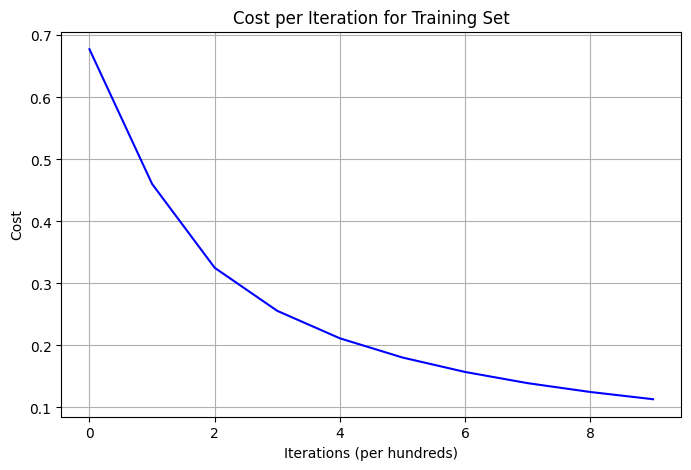

In [21]:
# Recall data variables: train_x_orig, train_y, val_x_orig, val_y

####################################################
# YOUR CODE STARTS HERE

# Define the dimensions of the layers
layers_dims = (train_x_orig.shape[0], 5, 1) #5 units in first hidden layer and 1 in output layer.


# Train the 2-layer network
parameters, costs_5 = two_layer_model(train_x_orig, train_y, layers_dims, init_scheme="glorot", num_iterations=1000, print_cost=True)

# Make predictions on training set
train_predictions, train_cost = predict(parameters, train_x_orig, train_y)

# Make predictions on test set
test_predictions, test_cost = predict(parameters, val_x_orig, val_y)

# Compute accuracy on training set
train_accuracy = accuracy_compute(train_predictions, train_y)

# Compute accuracy on test set
test_accuracy = accuracy_compute(test_predictions, val_y)

print("\nTraining Set Accuracy: {}% ".format(train_accuracy))
print("Test Set Accuracy: {}%".format(test_accuracy))

# YOUR CODE ENDS HERE
#####################################################
plt.figure(figsize=(8, 5))
plt.plot(costs_5, 'b')
plt.ylabel('Cost')
plt.xlabel('Iterations (per hundreds)')
plt.title('Cost per Iteration for Training Set')
plt.grid(":")
plt.show()
##### Plotting the training accuracy######

**Repeating steps 1 and 2 for  𝑛[1]∈50,200,500,1000.**


Training with 5 hidden units:
Cost after iteration 0: 0.6776793499228049
Cost after iteration 100: 0.4605073574403224
Cost after iteration 200: 0.32522837020366585
Cost after iteration 300: 0.2557577240622877
Cost after iteration 400: 0.21147881524815823
Cost after iteration 500: 0.18052083168095287
Cost after iteration 600: 0.15724476328365314
Cost after iteration 700: 0.1391900674389136
Cost after iteration 800: 0.12495589593588789
Cost after iteration 900: 0.11332454037997791
Cost after iteration 999: 0.10372311773609344


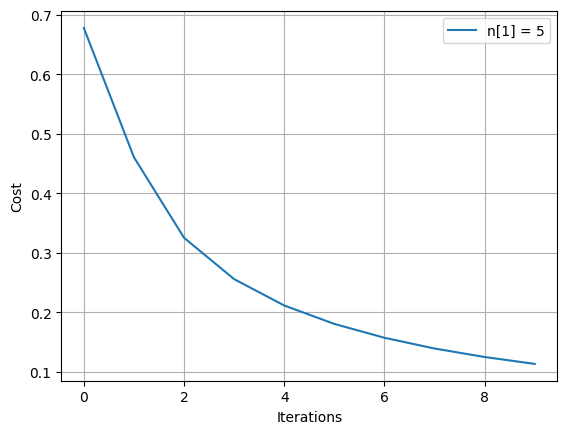


Training Set Accuracy: 97.18543046357615% 
Test Set Accuracy: 90.26845637583892%

Training with 50 hidden units:
Cost after iteration 0: 0.8055805094765786
Cost after iteration 100: 0.39778324448307495
Cost after iteration 200: 0.3001032530621126
Cost after iteration 300: 0.24083286299201806
Cost after iteration 400: 0.19918139290811235
Cost after iteration 500: 0.16861647472145064
Cost after iteration 600: 0.14483247683604894
Cost after iteration 700: 0.12668445281303414
Cost after iteration 800: 0.11197972611093396
Cost after iteration 900: 0.09992197977519758
Cost after iteration 999: 0.08999149508435171


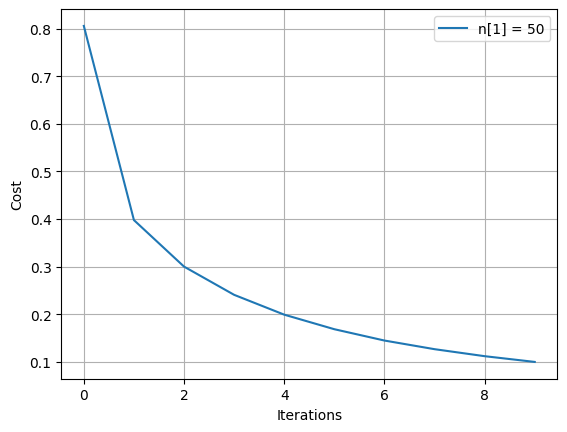


Training Set Accuracy: 98.17880794701986% 
Test Set Accuracy: 92.61744966442953%

Training with 200 hidden units:
Cost after iteration 0: 0.7441804387336289
Cost after iteration 100: 0.37849532317759793
Cost after iteration 200: 0.28705097449374406
Cost after iteration 300: 0.23324272087670633
Cost after iteration 400: 0.1956323081847538
Cost after iteration 500: 0.1677377226267922
Cost after iteration 600: 0.14600740521971134
Cost after iteration 700: 0.1286876607767122
Cost after iteration 800: 0.11452312858835158
Cost after iteration 900: 0.10253770120534146
Cost after iteration 999: 0.09268770841855892


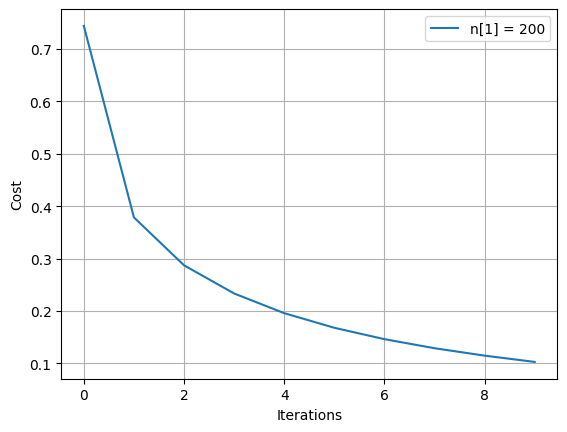


Training Set Accuracy: 98.17880794701986% 
Test Set Accuracy: 91.2751677852349%

Training with 500 hidden units:
Cost after iteration 0: 0.7307513966052899
Cost after iteration 100: 0.3495069507555502
Cost after iteration 200: 0.2648850663391964
Cost after iteration 300: 0.21481878935035095
Cost after iteration 400: 0.18047826261450112
Cost after iteration 500: 0.1547158671405712
Cost after iteration 600: 0.13494522392846636
Cost after iteration 700: 0.11914106562203476
Cost after iteration 800: 0.10620032820386395
Cost after iteration 900: 0.09548632041167919
Cost after iteration 999: 0.0864964480575677


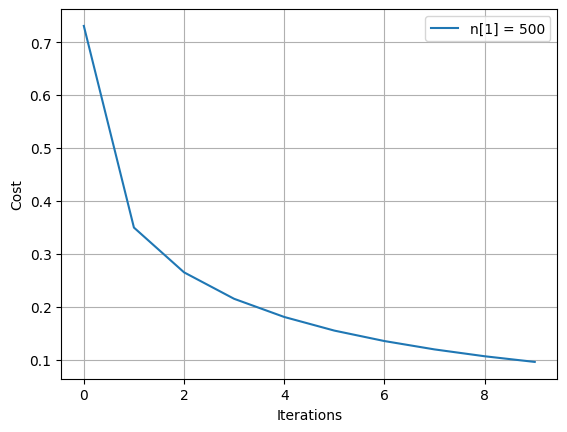


Training Set Accuracy: 98.17880794701986% 
Test Set Accuracy: 92.95302013422818%

Training with 1000 hidden units:
Cost after iteration 0: 0.750583594884623
Cost after iteration 100: 0.34613497768567547
Cost after iteration 200: 0.26229176302857343
Cost after iteration 300: 0.21180877676682278
Cost after iteration 400: 0.1771029490111047
Cost after iteration 500: 0.1515589699926686
Cost after iteration 600: 0.1319169332347416
Cost after iteration 700: 0.11623686988789
Cost after iteration 800: 0.1035501262411405
Cost after iteration 900: 0.09305531315322796
Cost after iteration 999: 0.08431198686869178


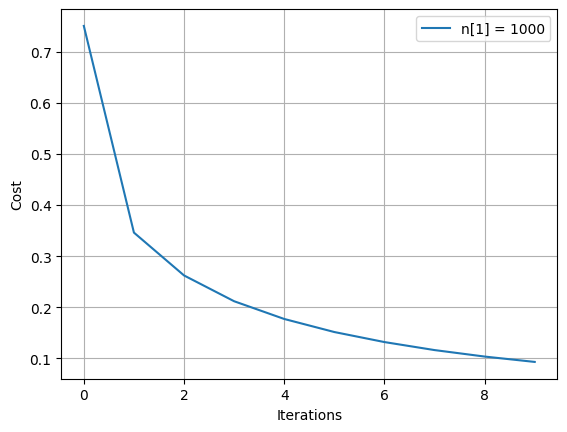


Training Set Accuracy: 98.50993377483444% 
Test Set Accuracy: 92.95302013422818%


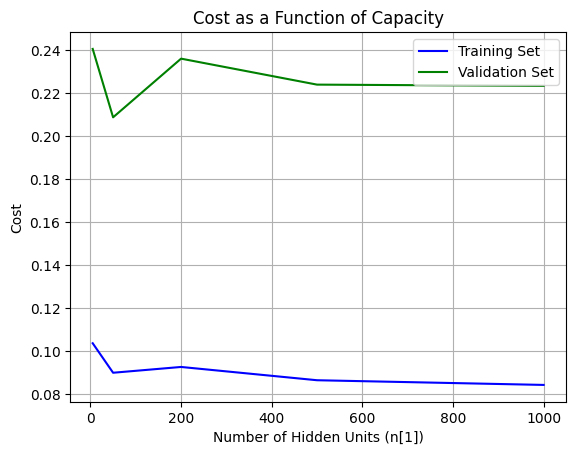

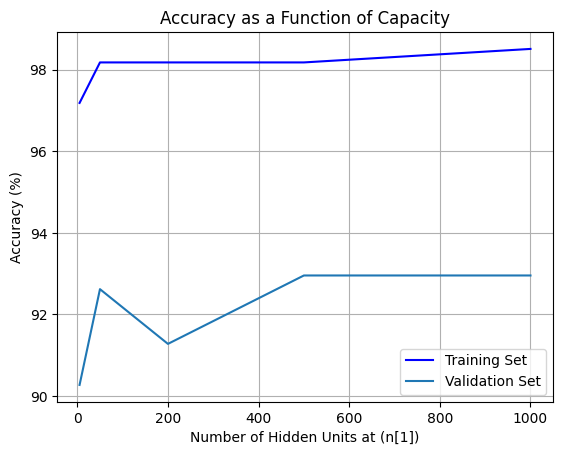

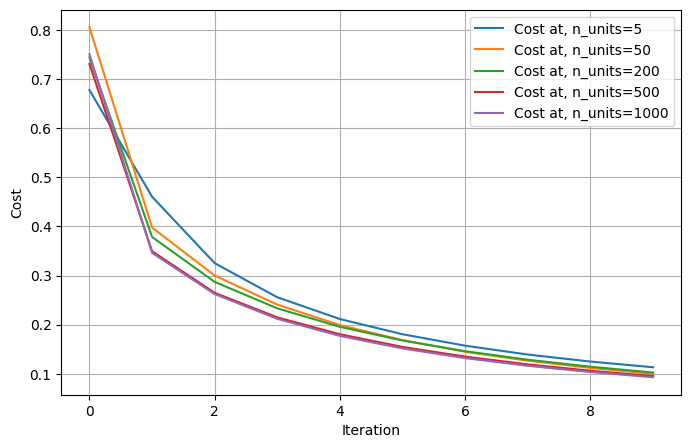

In [22]:
# Initialize variables
n_units_list = [5, 50, 200, 500, 1000]
costs_train = []
costs_val = []
total_cost= {}
accuracies_train = []
accuracies_val = []

# Loop through different hidden units
for n_units in n_units_list:
    print(f"\nTraining with {n_units} hidden units:")

    # Build the model
    layers_dims = [train_x_orig.shape[0], n_units, 1]  #5 units in first hidden layer and 1 in output layer.

    parameters, costs = two_layer_model(train_x_orig, train_y, layers_dims, init_scheme="glorot", num_iterations=1000, print_cost=True)

    # Plot cost per iteration
    plt.plot(costs, label=f'n[1] = {n_units}')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.grid(":")
    plt.legend()
    plt.show()

    total_cost[n_units] = costs

    # Evaluate accuracy on training set
    train_predictions, train_cost = predict(parameters, train_x_orig, train_y)
    accuracy_train = accuracy_compute(train_predictions, train_y)
    accuracies_train.append(accuracy_train)

    # Evaluate accuracy on validation set
    val_predictions, val_cost = predict(parameters, val_x_orig, val_y)
    accuracy_val = accuracy_compute(val_predictions, val_y)
    accuracies_val.append(accuracy_val)

    # Store costs for training and validation
    costs_train.append(train_cost)
    costs_val.append(val_cost)

    print("\nTraining Set Accuracy: {}% ".format(accuracy_train))
    print("Test Set Accuracy: {}%".format(accuracy_val))

# Plot cost as a function of capacity
plt.plot(n_units_list, costs_train, 'b', label='Training Set')
plt.plot(n_units_list, costs_val, 'g', label='Validation Set')
plt.xlabel('Number of Hidden Units (n[1])')
plt.ylabel('Cost')
plt.title('Cost as a Function of Capacity')
plt.grid(":")
plt.legend(loc)
plt.show()

# Plot accuracy as a function of capacity
plt.plot(n_units_list, accuracies_train, 'b', label='Training Set')
plt.plot(n_units_list, accuracies_val, label='Validation Set')
plt.xlabel('Number of Hidden Units at (n[1])')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy as a Function of Capacity')
plt.grid(":")
plt.legend()
plt.show()


# Plot cost as a function of capacity
plt.figure(figsize=(8, 5))
for n_units in n_units_list:
    plt.plot(total_cost[n_units], label=f'Cost at, n_units={n_units}')

plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.grid(":")
plt.legend()
#plt.title('Cost as a Function of Capacity')
plt.legend()
plt.show()


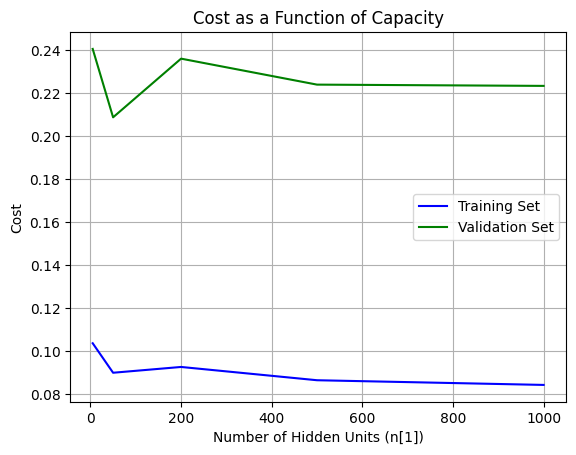

In [39]:
plt.plot(n_units_list, costs_train, 'b', label='Training Set')
plt.plot(n_units_list, costs_val, 'g', label='Validation Set')
plt.xlabel('Number of Hidden Units (n[1])')
plt.ylabel('Cost')
plt.title('Cost as a Function of Capacity')
plt.grid(":")
plt.legend(loc='center right')
plt.show()

Fine-tunning and optimal hyperparameter selection

Cost after iteration 0: 0.7307513966052899
Cost after iteration 100: 0.3495069507555502
Cost after iteration 200: 0.2648850663391964
Cost after iteration 300: 0.21481878935035095
Cost after iteration 400: 0.18047826261450112
Cost after iteration 500: 0.1547158671405712
Cost after iteration 600: 0.13494522392846636
Cost after iteration 700: 0.11914106562203476
Cost after iteration 800: 0.10620032820386395
Cost after iteration 900: 0.09548632041167919
Cost after iteration 1000: 0.08641217634163904
Cost after iteration 1100: 0.07863509993783004
Cost after iteration 1200: 0.07193411446700711
Cost after iteration 1300: 0.06609370558853102
Cost after iteration 1400: 0.060961732579851546
Cost after iteration 1500: 0.056429683853499266
Cost after iteration 1600: 0.05240501278195794
Cost after iteration 1700: 0.048804066418462876
Cost after iteration 1800: 0.04557783901722351
Cost after iteration 1900: 0.04267378004297123
Cost after iteration 2000: 0.040019789626719905
Cost after iteration 2100

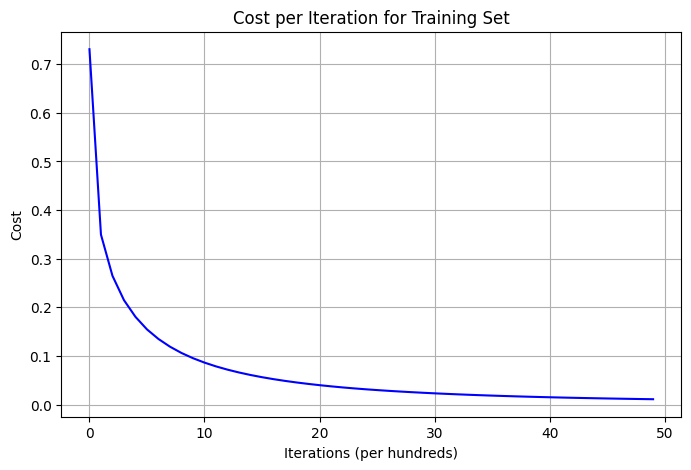

In [23]:
#fine tunning and optimal hyperparameter selection

####################################################
# YOUR CODE STARTS HERE

# Define the dimensions of the layers
layers_dims = (train_x_orig.shape[0], 500, 1) #5 units in first hidden layer and 1 in output layer.


# Train the 2-layer network
parameters, costs_5 = two_layer_model(train_x_orig, train_y, layers_dims, init_scheme="glorot", num_iterations=5000, print_cost=True)

# Make predictions on training set
train_predictions, train_cost = predict(parameters, train_x_orig, train_y)

# Make predictions on test set
test_predictions, test_cost = predict(parameters, val_x_orig, val_y)

# Compute accuracy on training set
train_accuracy = accuracy_compute(train_predictions, train_y)

# Compute accuracy on test set
test_accuracy = accuracy_compute(test_predictions, val_y)

print("\nTraining Set Accuracy: {}% ".format(train_accuracy))
print("Test Set Accuracy: {}%".format(test_accuracy))

# YOUR CODE ENDS HERE
#####################################################
plt.figure(figsize=(8, 5))
plt.plot(costs_5, 'b')
plt.ylabel('Cost')
plt.xlabel('Iterations (per hundreds)')
plt.title('Cost per Iteration for Training Set')
plt.grid(":")
plt.show()
##### Plotting the training accuracy######

## 4 - L-layer Neural Network [Points: 15]

Use the functions you implemented previously to build an $L$-layer neural network with the following structure: Inputs -> ReLU Layers * (L-1) -> Sigmoid Output Layer.


The functions, input arguments, and outputs are:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

**Make sure your 2-Layer Network works, before continuing with this exercise.**

### 4.1 Build N-Layer Network function [Points: ]

In [24]:
def L_layer_model(X, Y, layers_dims, init_scheme, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network.

    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if face, 0 if background), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    init_scheme -- Tuple with ("small_normal", factor) or ("glorot", factor). See initialize_parameters_deep
    function for more details. Note that when using "glorot", factor is ignored.
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps

    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    #######################################################
    # YOUR CODE STARTS HERE
    np.random.seed(1)
    costs = []  # keep track of cost

    # Initialize parameters
    parameters = initialize_parameters_deep(layers_dims, init_scheme)

    for i in range(0, num_iterations):

        # Forward propagation
        A, caches = L_model_forward(X, parameters)

        # Compute cost
        cost = compute_cost(A, Y)

        # Backward propagation
        grads = L_model_backward(A, Y, caches)

        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    # YOUR CODE ENDS HERE
    ###############################################################################


    return parameters, costs

### 4.2 - Train the model

Build a 4-layer network with hidden layers 1, 2, and 3 with 51, 25, and 15 units respectively.

- The cost should decrease on every iteration.
- It may take up to 5 minutes to run 5000 iterations.


**Write-up required**

Cost after iteration 0: 0.6749267592016422
Cost after iteration 100: 0.36407397879101255
Cost after iteration 200: 0.23922639914705088
Cost after iteration 300: 0.1637709758592497
Cost after iteration 400: 0.10427165586903597
Cost after iteration 500: 0.07425952583730822
Cost after iteration 600: 0.054909365358916655
Cost after iteration 700: 0.042836203436861446
Cost after iteration 800: 0.034128767799438166
Cost after iteration 900: 0.027817046657090935
Cost after iteration 1000: 0.02305874561918141
Cost after iteration 1100: 0.019346508055714116
Cost after iteration 1200: 0.016370478988601965
Cost after iteration 1300: 0.013989216878956545
Cost after iteration 1400: 0.012022385723283334
Cost after iteration 1500: 0.010443001716431933
Cost after iteration 1600: 0.009126263097241877
Cost after iteration 1700: 0.008069878638268423
Cost after iteration 1800: 0.007194634186247626
Cost after iteration 1900: 0.006473298645576594
Cost after iteration 2000: 0.005868187657111762
Cost after it

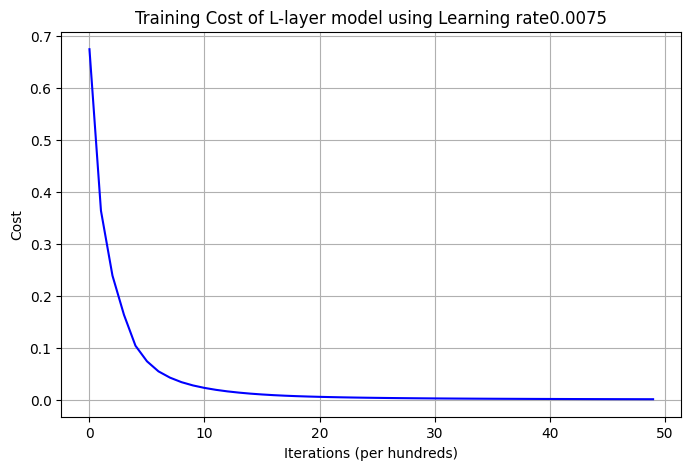

In [25]:
# Recall data variables: train_x_orig, train_y, val_x_orig, val_y

####################################################
# YOUR CODE STARTS HERE

# Set up the layer dimensions
layers_dims = [train_x_orig.shape[0], 51, 25, 15, 1] #51, 25, 15 and 1 units are used in 1, 2 and 3 hidden layers, respectively. The last 1 in output layer.

# Set up hyperparameters
#learning_rate = 0.0075

# Build and train the l-layer model
parameters, costs = L_layer_model(train_x_orig, train_y, layers_dims, init_scheme="glorot", learning_rate= 0.0075, num_iterations=5000, print_cost=True)

# Make predictions on training set
train_predictions, train_cost = predict(parameters, train_x_orig, train_y)

# Make predictions on test set
test_predictions, test_cost = predict(parameters, val_x_orig, val_y)

# Compute accuracy on training set
train_accuracy = accuracy_compute(train_predictions, train_y)

# Compute accuracy on test set
test_accuracy = accuracy_compute(test_predictions, val_y)

print("\nTraining Set Accuracy: {}% ".format(train_accuracy))
print("Test Set Accuracy: {}%".format(test_accuracy))

##### Plotting the training accuracy######
plt.figure(figsize=(8, 5))
plt.plot(np.squeeze(costs), 'b')
plt.ylabel('Cost')
plt.xlabel('Iterations (per hundreds)')
plt.title('Training Cost of L-layer model using Learning rate'+str(0.0075))
plt.grid(":")
plt.show()

# YOUR CODE ENDS HERE
####################################################



---

# Remaining sections of homework are mandatory for COSC 525 students and bonus for COSC 424 students

---

## 5.0 Hyper-parameter exploration, results analysis, and self-test [Points: 20]

### 5.1 Explore your hyperparameters.

- Build at least three different networks that vary in depth and number of hidden units.
- Also, explore the impact of learning rate and initialization scheme on model performance.
- Document your observations
    1. Compare capacity of networks
    2. Provide cost vs iteration and cost vs capacity plots
    3. Select best parameters and thoroughly explain your decision.

**Write-up required**

Cost after iteration 0: 0.6942349437075961
Cost after iteration 100: 0.5061562594048575
Cost after iteration 200: 0.36760851914141857
Cost after iteration 300: 0.2701851203859439
Cost after iteration 400: 0.20510796253703403
Cost after iteration 500: 0.15927540320909284
Cost after iteration 600: 0.1268743464024966
Cost after iteration 700: 0.10341909684378238
Cost after iteration 800: 0.0858220581507677
Cost after iteration 900: 0.07227595079429902
Cost after iteration 1000: 0.06156417282413228
Cost after iteration 1100: 0.052958444911898016
Cost after iteration 1200: 0.04600167422507082
Cost after iteration 1300: 0.040200661048919645
Cost after iteration 1400: 0.035388210240140626
Cost after iteration 1500: 0.031373407310932806
Cost after iteration 1600: 0.0280635521493663
Cost after iteration 1700: 0.02507577677721058
Cost after iteration 1800: 0.02262837912310845
Cost after iteration 1900: 0.02039476190446475
Cost after iteration 2000: 0.01855945857976772
Cost after iteration 2100: 

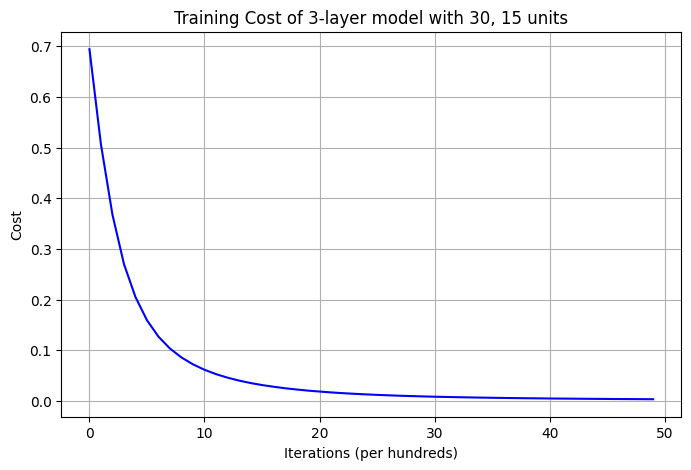

Cost after iteration 0: 0.6788736925067902
Cost after iteration 100: 0.4192729701403458
Cost after iteration 200: 0.27929043969318834
Cost after iteration 300: 0.21514809431707796
Cost after iteration 400: 0.15807235351066454
Cost after iteration 500: 0.10832126937045908
Cost after iteration 600: 0.08146682604636082
Cost after iteration 700: 0.06143328961890769
Cost after iteration 800: 0.048335187781090146
Cost after iteration 900: 0.038862591195764906
Cost after iteration 1000: 0.031767242502785266
Cost after iteration 1100: 0.026267721384544106
Cost after iteration 1200: 0.02195560422363298
Cost after iteration 1300: 0.018472182227428493
Cost after iteration 1400: 0.015605227148725911
Cost after iteration 1500: 0.01332034729224939
Cost after iteration 1600: 0.01146771257898446
Cost after iteration 1700: 0.009985549839554332
Cost after iteration 1800: 0.008771713971546424
Cost after iteration 1900: 0.007772299728318021
Cost after iteration 2000: 0.006945807281578601
Cost after iterat

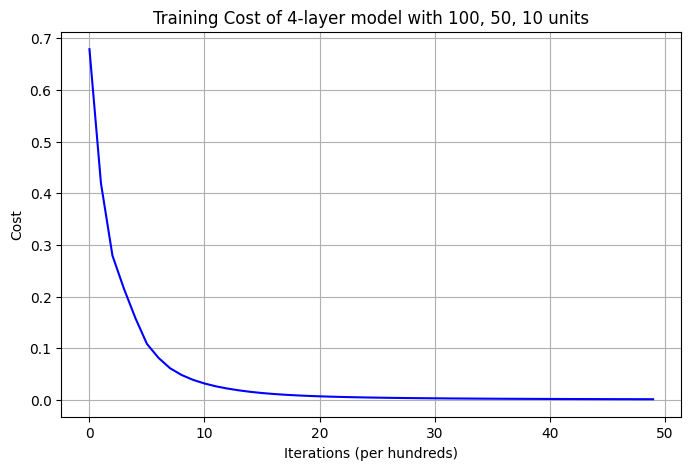

Cost after iteration 0: 0.6761466808980962
Cost after iteration 100: 0.3807229744181771
Cost after iteration 200: 0.2508165778993933
Cost after iteration 300: 0.17613688156380655
Cost after iteration 400: 0.11906206520665173
Cost after iteration 500: 0.0865288510173929
Cost after iteration 600: 0.0545035914889487
Cost after iteration 700: 0.0368451687329324
Cost after iteration 800: 0.02787116830625286
Cost after iteration 900: 0.02183262541727465
Cost after iteration 1000: 0.01740470491234405
Cost after iteration 1100: 0.014062918841202504
Cost after iteration 1200: 0.01151337877211295
Cost after iteration 1300: 0.009556788350652835
Cost after iteration 1400: 0.008052260459211893
Cost after iteration 1500: 0.006890616508461481
Cost after iteration 1600: 0.005975322473707349
Cost after iteration 1700: 0.005238329112282796
Cost after iteration 1800: 0.00461646566151897
Cost after iteration 1900: 0.004145981923286405
Cost after iteration 2000: 0.0037560816954110275
Cost after iteration 2

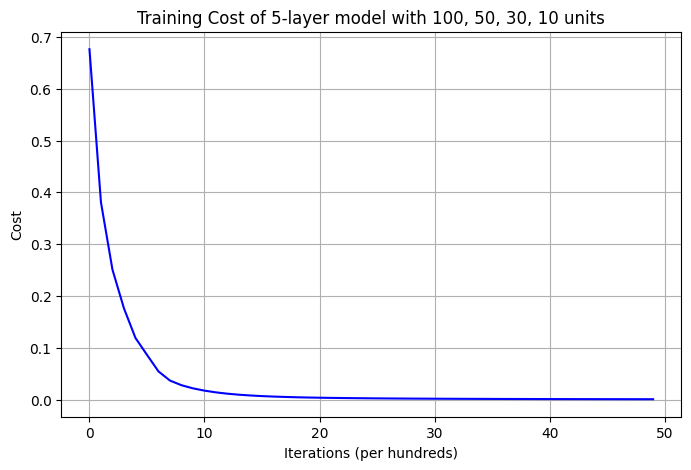

Cost after iteration 0: 0.6867776418797329
Cost after iteration 100: 0.44129239441265516
Cost after iteration 200: 0.3601193860638705
Cost after iteration 300: 0.2726561972291773
Cost after iteration 400: 0.1873036762436624
Cost after iteration 500: 0.12770587731144117
Cost after iteration 600: 0.07201576812657305
Cost after iteration 700: 0.044063344848848045
Cost after iteration 800: 0.03069046281203939
Cost after iteration 900: 0.022492169130731147
Cost after iteration 1000: 0.016963089116675052
Cost after iteration 1100: 0.012842834963702225
Cost after iteration 1200: 0.009886711539176342
Cost after iteration 1300: 0.007786151462540166
Cost after iteration 1400: 0.006309528041424701
Cost after iteration 1500: 0.005250595489167905
Cost after iteration 1600: 0.004471234489195829
Cost after iteration 1700: 0.003875921786486347
Cost after iteration 1800: 0.00340989953310813
Cost after iteration 1900: 0.003038171531202356
Cost after iteration 2000: 0.0027354765423349427
Cost after itera

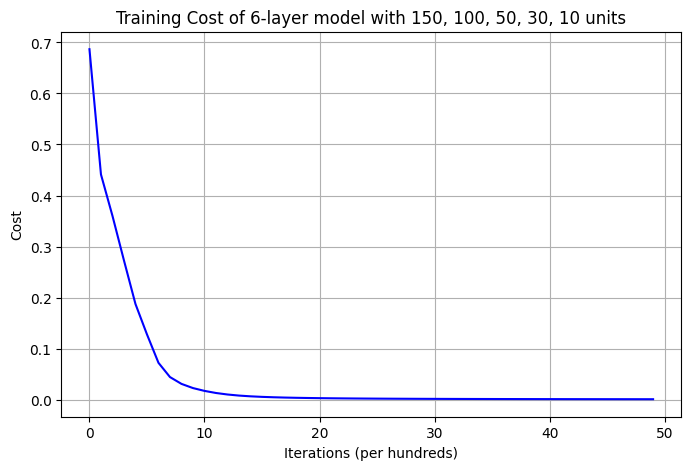

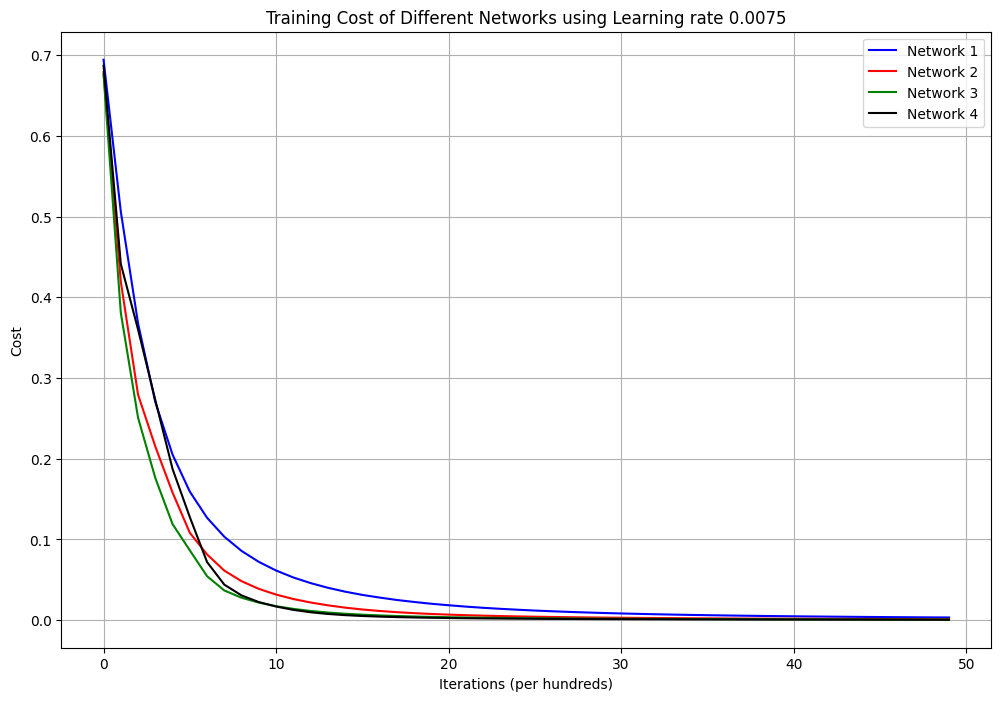

In [27]:

####################################################
# YOUR CODE STARTS HERE

# Network 1: 3-layer network with hidden layer sizes 20 and 10
layers_dims_1 = [train_x_orig.shape[0], 30, 15, 1]
parameters_1, costs_1 = L_layer_model(train_x_orig, train_y, layers_dims_1, init_scheme="glorot", learning_rate=0.0075, num_iterations=5000, print_cost=True)
train_predictions_1, train_cost_1 = predict(parameters_1, train_x_orig, train_y)
test_predictions_1, test_cost_1 = predict(parameters_1, val_x_orig, val_y)
train_accuracy_1 = accuracy_compute(train_predictions_1, train_y)
test_accuracy_1 = accuracy_compute(test_predictions_1, val_y)
print("\nNetwork 1:")
print("Training Set Accuracy: {}% ".format(train_accuracy_1))
print("Test Set Accuracy: {}%".format(test_accuracy_1))

##### Plotting the cost versus iteration accuracy######
plt.figure(figsize=(8, 5))
plt.plot(np.squeeze(costs_1), 'b')
plt.ylabel('Cost')
plt.xlabel('Iterations (per hundreds)')
plt.title('Training Cost of 3-layer model with 30, 15 units')
plt.grid(":")
plt.show()

# Network 2: 4-layer network with hidden layer sizes 100, 50, and 10
layers_dims_2 = [train_x_orig.shape[0], 100, 50, 10, 1]
parameters_2, costs_2 = L_layer_model(train_x_orig, train_y, layers_dims_2, init_scheme="glorot", learning_rate=0.0075, num_iterations=5000, print_cost=True)
train_predictions_2, train_cost_2 = predict(parameters_2, train_x_orig, train_y)
test_predictions_2, test_cost_2 = predict(parameters_2, val_x_orig, val_y)
train_accuracy_2 = accuracy_compute(train_predictions_2, train_y)
test_accuracy_2 = accuracy_compute(test_predictions_2, val_y)
print("\nNetwork 2:")
print("Training Set Accuracy: {}% ".format(train_accuracy_2))
print("Test Set Accuracy: {}%".format(test_accuracy_2))


##### Plotting the cost versus iteration accuracy######
plt.figure(figsize=(8, 5))
plt.plot(np.squeeze(costs_2), 'b')
plt.ylabel('Cost')
plt.xlabel('Iterations (per hundreds)')
plt.title('Training Cost of 4-layer model with 100, 50, 10 units')
plt.grid(":")
plt.show()

# Network 3: 5-layer network with hidden layer sizes 100, 50, 30, and 10
layers_dims_3 = [train_x_orig.shape[0], 100, 50, 30, 10, 1]
parameters_3, costs_3 = L_layer_model(train_x_orig, train_y, layers_dims_3, init_scheme="glorot", learning_rate=0.0075, num_iterations=5000, print_cost=True)
train_predictions_3, train_cost_3 = predict(parameters_3, train_x_orig, train_y)
test_predictions_3, test_cost_3 = predict(parameters_3, val_x_orig, val_y)
train_accuracy_3 = accuracy_compute(train_predictions_3, train_y)
test_accuracy_3 = accuracy_compute(test_predictions_3, val_y)
print("\nNetwork 3:")
print("Training Set Accuracy: {}% ".format(train_accuracy_3))
print("Test Set Accuracy: {}%".format(test_accuracy_3))


##### Plotting the cost versus iteration accuracy######
plt.figure(figsize=(8, 5))
plt.plot(np.squeeze(costs_3), 'b')
plt.ylabel('Cost')
plt.xlabel('Iterations (per hundreds)')
plt.title('Training Cost of 5-layer model with 100, 50, 30, 10 units')
plt.grid(":")
plt.show()


# Network 4: 6-layer network with hidden layer sizes 150, 100, 50, 30, and 10
layers_dims_3 = [train_x_orig.shape[0], 150, 100, 50, 30, 10, 1]
parameters_4, costs_4 = L_layer_model(train_x_orig, train_y, layers_dims_3, init_scheme="glorot", learning_rate=0.0075, num_iterations=5000, print_cost=True)
train_predictions_4, train_cost_4 = predict(parameters_4, train_x_orig, train_y)
test_predictions_4, test_cost_4 = predict(parameters_4, val_x_orig, val_y)
train_accuracy_4 = accuracy_compute(train_predictions_4, train_y)
test_accuracy_4 = accuracy_compute(test_predictions_4, val_y)
print("\nNetwork 4:")
print("Training Set Accuracy: {}% ".format(train_accuracy_4))
print("Test Set Accuracy: {}%".format(test_accuracy_4))


##### Plotting the cost versus iteration accuracy######
plt.figure(figsize=(8, 5))
plt.plot(np.squeeze(costs_4), 'b')
plt.ylabel('Cost')
plt.xlabel('Iterations (per hundreds)')
plt.title('Training Cost of 6-layer model with 150, 100, 50, 30, 10 units')
plt.grid(":")
plt.show()


# Plotting the training cost
plt.figure(figsize=(12, 8))
plt.plot(np.squeeze(costs_1), 'b', label='Network 1')
plt.plot(np.squeeze(costs_2), 'r', label='Network 2')
plt.plot(np.squeeze(costs_3), 'g', label='Network 3')
plt.plot(np.squeeze(costs_4), color='black', label='Network 4')
plt.ylabel('Cost')
plt.xlabel('Iterations (per hundreds)')
plt.title('Training Cost of Different Networks using Learning rate 0.0075')
plt.legend()
plt.grid(":")
plt.show()

# YOUR CODE ENDS HERE
####################################################

The cost vs iteration and cost vs capacity plots

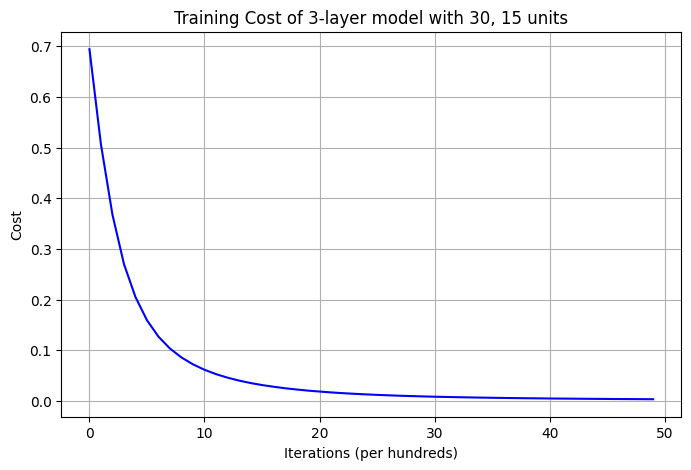

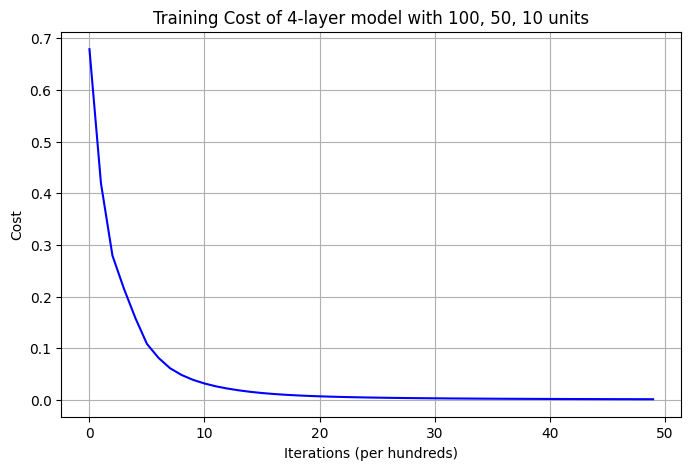

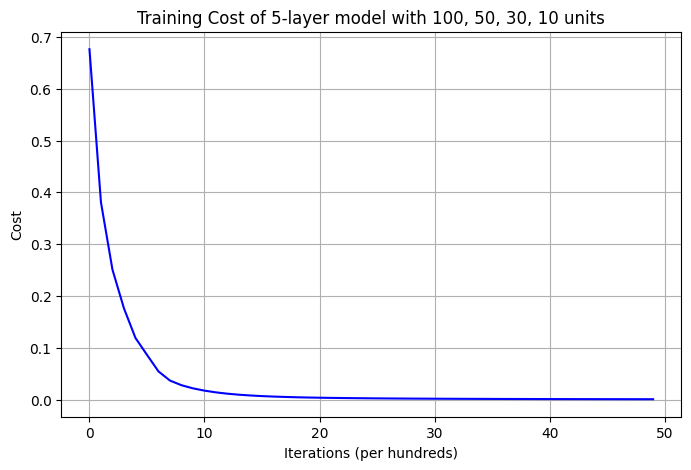

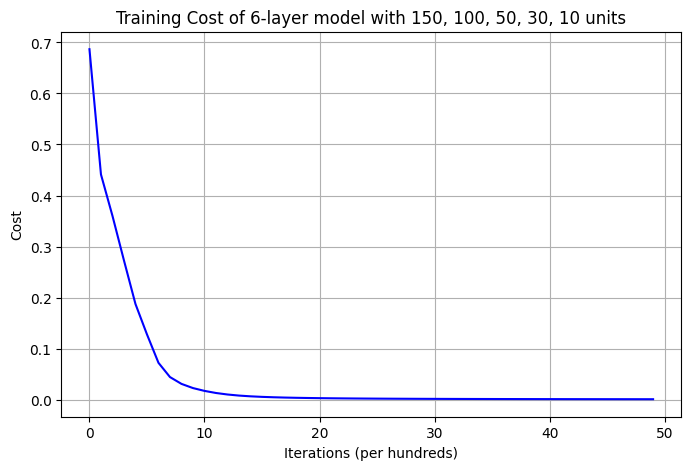

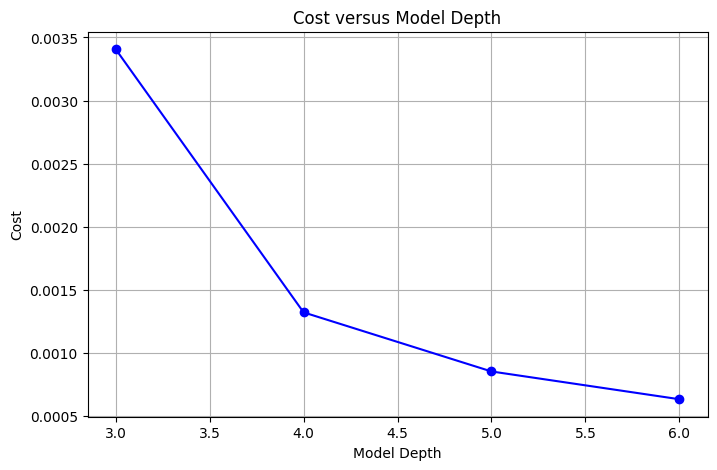

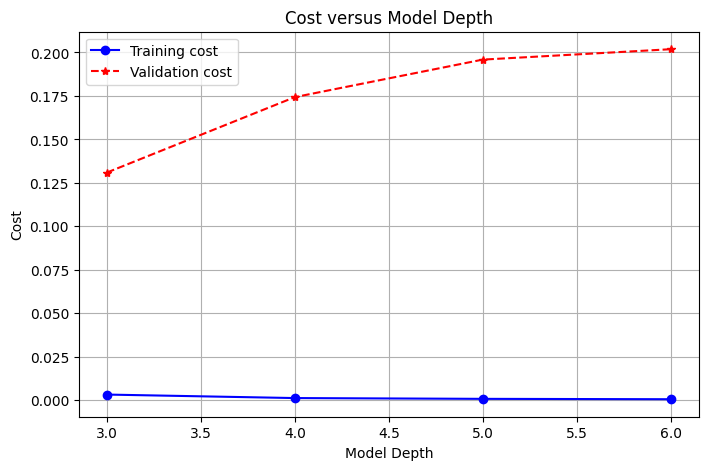

In [28]:
##### Plotting the cost versus iteration accuracy of Network 1 ######
plt.figure(figsize=(8, 5))
plt.plot(np.squeeze(costs_1), 'b')
plt.ylabel('Cost')
plt.xlabel('Iterations (per hundreds)')
plt.title('Training Cost of 3-layer model with 30, 15 units')
plt.grid(":")
plt.show()

##### Plotting the cost versus iteration accuracy of Network 2 ######
plt.figure(figsize=(8, 5))
plt.plot(np.squeeze(costs_2), 'b')
plt.ylabel('Cost')
plt.xlabel('Iterations (per hundreds)')
plt.title('Training Cost of 4-layer model with 100, 50, 10 units')
plt.grid(":")
plt.show()

##### Plotting the cost versus iteration accuracy of Network 3 ######
plt.figure(figsize=(8, 5))
plt.plot(np.squeeze(costs_3), 'b')
plt.ylabel('Cost')
plt.xlabel('Iterations (per hundreds)')
plt.title('Training Cost of 5-layer model with 100, 50, 30, 10 units')
plt.grid(":")
plt.show()

##### Plotting the cost versus iteration accuracy of Network 4 ######
plt.figure(figsize=(8, 5))
plt.plot(np.squeeze(costs_4), 'b')
plt.ylabel('Cost')
plt.xlabel('Iterations (per hundreds)')
plt.title('Training Cost of 6-layer model with 150, 100, 50, 30, 10 units')
plt.grid(":")
plt.show()

costs_by_capacity = []
tr_costs_by_capacity=[]
val_costs_by_capacity=[]

costs_by_capacity.append(costs_1[-1])
costs_by_capacity.append(costs_2[-1])
costs_by_capacity.append(costs_3[-1])
costs_by_capacity.append(costs_4[-1])

tr_costs_by_capacity.append(train_cost_1)
val_costs_by_capacity.append(test_cost_1)

tr_costs_by_capacity.append(train_cost_2)
val_costs_by_capacity.append(test_cost_2)

tr_costs_by_capacity.append(train_cost_3)
val_costs_by_capacity.append(test_cost_3)

tr_costs_by_capacity.append(train_cost_4)
val_costs_by_capacity.append(test_cost_4)
##### Plotting the cost versus network depths ######
depths = [3, 4, 5, 6]
# Plot cost versus model depths
plt.figure(figsize=(8, 5))
plt.plot(depths, costs_by_capacity, marker='o', color='b', linestyle='-')
plt.xlabel('Model Depth')
plt.ylabel('Cost')
plt.title('Cost versus Model Depth')
plt.grid(True)
plt.show()

##### Plotting the cost versus network depths at training ######
depths = [3, 4, 5, 6]
# Plot cost versus model depths
plt.figure(figsize=(8, 5))
plt.plot(depths, tr_costs_by_capacity, marker='o', color='b', linestyle='-', label='Training cost')
plt.plot(depths, val_costs_by_capacity, marker='*', color='r', linestyle='--', label='Validation cost')
plt.xlabel('Model Depth')
plt.ylabel('Cost')
plt.title('Cost versus Model Depth')
plt.grid(True)
plt.legend()
plt.show()


**Testing for different learning rates with optimal selected 4th network **

Cost after iteration 0: 0.6867776418797329
Cost after iteration 100: 0.4715117897006493
Cost after iteration 200: 0.3306189645626116
Cost after iteration 300: 0.2454285667489502
Cost after iteration 400: 0.17626229548391067
Cost after iteration 500: 0.09724728927873369
Cost after iteration 600: 0.052213658639836937
Cost after iteration 700: 0.02696402263379722
Cost after iteration 800: 0.018181924070966436
Cost after iteration 900: 0.012965325033212467
Cost after iteration 1000: 0.009409625977331512
Cost after iteration 1100: 0.006960469935930772
Cost after iteration 1200: 0.00538793769855338
Cost after iteration 1300: 0.004345851384175153
Cost after iteration 1400: 0.0036128577234931757
Cost after iteration 1500: 0.003077676510764734
Cost after iteration 1600: 0.002672908763567232
Cost after iteration 1700: 0.002353754653509418
Cost after iteration 1800: 0.0020993465161992225
Cost after iteration 1900: 0.0018910117523373746
Cost after iteration 2000: 0.0017184113416349902
Cost after i

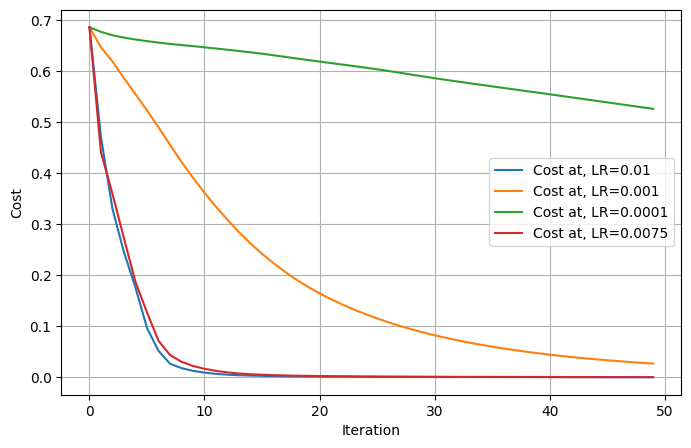

In [29]:
##Here, using the optimal network architecture, try different learning rates to check the impact.

# Set up the layer dimensions
layers_dims = [train_x_orig.shape[0], 150, 100, 50, 30, 10, 1]  # Architecture of the network

# Set up different learning rates and initialization schemes to explore
learning_rates = [0.01, 0.001, 0.0001, 0.0075]

total_lr_cost= {}
# Iterate over different learning rates and initialization schemes
for learning_rate in learning_rates:

        # Build and train the l-layer model
        parameters, costs = L_layer_model(train_x_orig, train_y, layers_dims, init_scheme="glorot", learning_rate=learning_rate, num_iterations=5000, print_cost=True)

        # Make predictions on training set
        train_predictions, train_cost = predict(parameters, train_x_orig, train_y)

        # Make predictions on test set
        test_predictions, test_cost = predict(parameters, val_x_orig, val_y)

        # Compute accuracy on training set
        train_accuracy = accuracy_compute(train_predictions, train_y)

        # Compute accuracy on test set
        test_accuracy = accuracy_compute(test_predictions, val_y)

        total_lr_cost[learning_rate] = costs

        # Print results

        print("Training Set Accuracy: {}% ".format(train_accuracy))
        print("Test Set Accuracy: {}%".format(test_accuracy))


# Plot cost as a function of capacity for differnet LRs.
plt.figure(figsize=(8, 5))
for learning_rate in learning_rates:
    plt.plot(total_lr_cost[learning_rate], label=f'Cost at, LR={learning_rate}')

plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.grid(":")
plt.legend()
#plt.title('Cost as a Function of Capacity')
plt.legend()
plt.show()


**Testing for different initialization schemes with optimal model**

Cost after iteration 0: 0.6931471848184945
Cost after iteration 100: 0.6919034179830381
Cost after iteration 200: 0.6911494178131418
Cost after iteration 300: 0.6906921765718412
Cost after iteration 400: 0.6904147894276893
Cost after iteration 500: 0.6902464470621256
Cost after iteration 600: 0.6901442470847365
Cost after iteration 700: 0.690082183155024
Cost after iteration 800: 0.6900444835377462
Cost after iteration 900: 0.6900215788231447
Cost after iteration 1000: 0.6900076605089586
Cost after iteration 1100: 0.6899992017468971
Cost after iteration 1200: 0.6899940603878769
Cost after iteration 1300: 0.6899909351884724
Cost after iteration 1400: 0.6899890353308086
Cost after iteration 1500: 0.6899878803609233
Cost after iteration 1600: 0.6899871781707518
Cost after iteration 1700: 0.6899867512531311
Cost after iteration 1800: 0.6899864916705649
Cost after iteration 1900: 0.6899863338389761
Cost after iteration 2000: 0.6899862378589833
Cost after iteration 2100: 0.6899861795410512
C

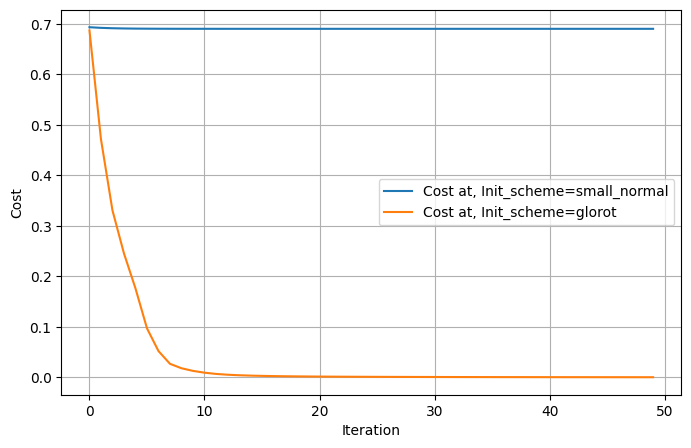

In [30]:
# Set up the layer dimensions
layers_dims = [train_x_orig.shape[0], 150, 100, 50, 30, 10, 1]  # Architecture of the network

# Set up different learning rates and initialization schemes to explore

init_schemes = ["small_normal", "glorot"]

total_init_cost= {}
# Iterate over different learning rates and initialization schemes
for init_scheme in init_schemes:
        # Build and train the l-layer model
        parameters, costs = L_layer_model(train_x_orig, train_y, layers_dims, init_scheme=init_scheme, learning_rate=0.01, num_iterations=5000, print_cost=True)

        # Make predictions on training set
        train_predictions, train_cost = predict(parameters, train_x_orig, train_y)

        # Make predictions on test set
        test_predictions, test_cost = predict(parameters, val_x_orig, val_y)

        # Compute accuracy on training set
        train_accuracy = accuracy_compute(train_predictions, train_y)

        # Compute accuracy on test set
        test_accuracy = accuracy_compute(test_predictions, val_y)

        total_init_cost[init_scheme] = costs

        # Print results

        print("Training Set Accuracy: {}% ".format(train_accuracy))
        print("Test Set Accuracy: {}%".format(test_accuracy))


# Plot cost as a function of capacity for differnet LRs.
plt.figure(figsize=(8, 5))
for init_scheme in init_schemes:
    plt.plot(total_init_cost[init_scheme], label=f'Cost at, Init_scheme={init_scheme}')

plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.grid(":")
plt.legend()
plt.legend()
plt.show()


**Selecting and training the model with optimal hyperparameters setting**

Cost after iteration 0: 0.6867776418797329
Cost after iteration 100: 0.4715117897006493
Cost after iteration 200: 0.3306189645626116
Cost after iteration 300: 0.2454285667489502
Cost after iteration 400: 0.17626229548391067
Cost after iteration 500: 0.09724728927873369
Cost after iteration 600: 0.052213658639836937
Cost after iteration 700: 0.02696402263379722
Cost after iteration 800: 0.018181924070966436
Cost after iteration 900: 0.012965325033212467
Cost after iteration 1000: 0.009409625977331512
Cost after iteration 1100: 0.006960469935930772
Cost after iteration 1200: 0.00538793769855338
Cost after iteration 1300: 0.004345851384175153
Cost after iteration 1400: 0.0036128577234931757
Cost after iteration 1500: 0.003077676510764734
Cost after iteration 1600: 0.002672908763567232
Cost after iteration 1700: 0.002353754653509418
Cost after iteration 1800: 0.0020993465161992225
Cost after iteration 1900: 0.0018910117523373746
Cost after iteration 2000: 0.0017184113416349902
Cost after i

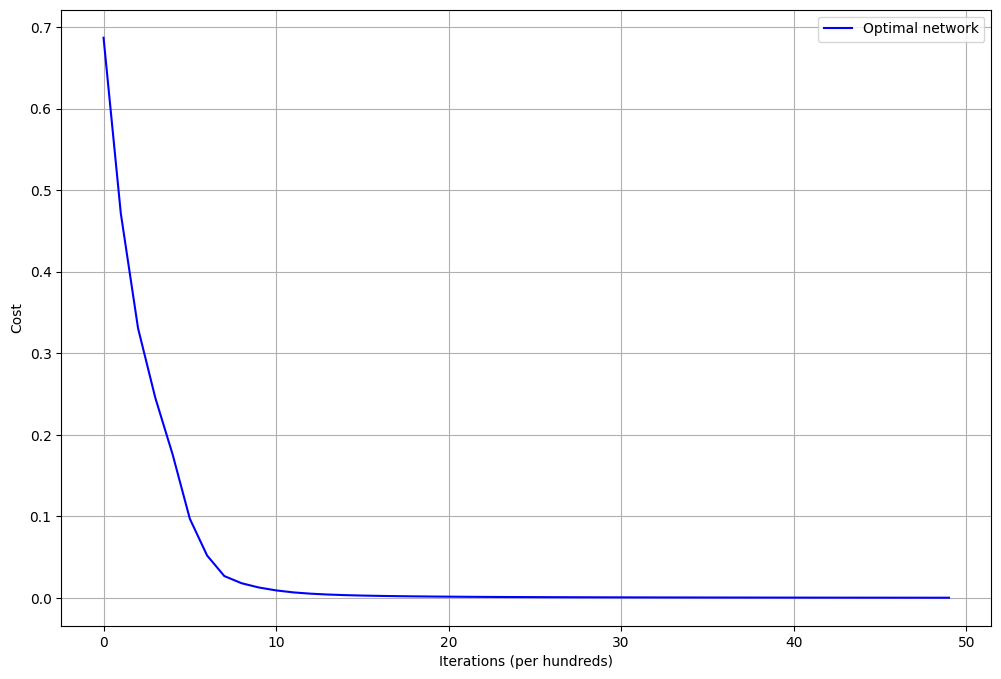

In [31]:
# Network 4: 6-layer network with hidden layer sizes 150, 100, 50, 30, 10, 1
layers_dims_3 = [train_x_orig.shape[0], 150, 100, 50, 30, 10, 1]
parameters_3, costs_3 = L_layer_model(train_x_orig, train_y, layers_dims_3, init_scheme="glorot", learning_rate=0.01, num_iterations=5000, print_cost=True)
train_predictions_3, train_cost_3 = predict(parameters_3, train_x_orig, train_y)
test_predictions_3, test_cost_3 = predict(parameters_3, val_x_orig, val_y)
train_accuracy_3 = accuracy_compute(train_predictions_3, train_y)
test_accuracy_3 = accuracy_compute(test_predictions_3, val_y)

print("Training Set Accuracy: {}% ".format(train_accuracy_3))
print("Test Set Accuracy: {}%".format(test_accuracy_3))

# Plotting the training cost
plt.figure(figsize=(12, 8))
plt.plot(np.squeeze(costs_3), 'b', label='Optimal network')
plt.ylabel('Cost')
plt.xlabel('Iterations (per hundreds)')
plt.legend()
plt.grid(":")
plt.show()


###  5.2 - Results Analysis

Visualize some of the model mistakes and document your intuition for these errors.

**Write-up required.**

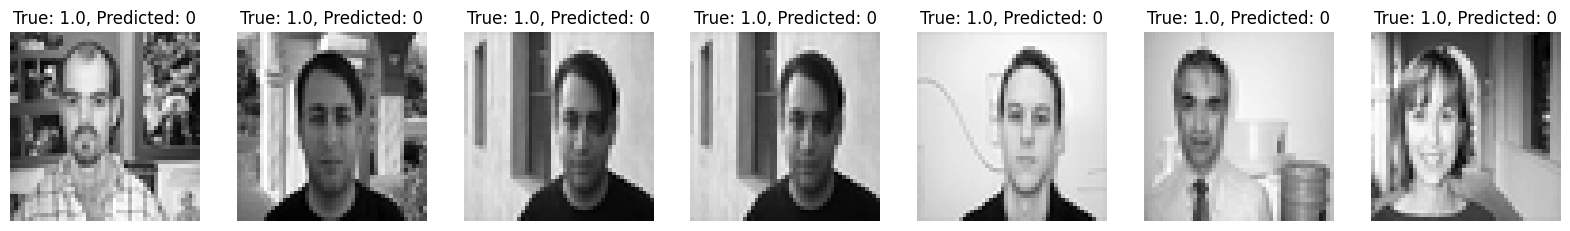

In [32]:
####################################################
# YOUR CODE STARTS HERE
def visualize_mistakes(predictions, true_labels, images, num_examples=7):
    """
    Visualize some of the model mistakes.

    Arguments:
    predictions -- predicted labels
    true_labels -- true labels
    images -- input images
    num_examples -- number of examples to visualize (default is 5)
    """

    # Find indices where the predictions are different from true labels
    mistake_indices = np.where(predictions != true_labels)[1]

    # Select 7 examples from the mistakes

    # Check if there are mistakes
    if len(mistake_indices) == 0:
        print("No mistakes found.")
        return
    else:
      selected_indices = np.random.choice(mistake_indices, size=num_examples)

    # Plot the selected examples
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(selected_indices, 1):
        plt.subplot(1, num_examples, i)
        plt.imshow(images[:, idx].reshape((50,50,1)))
        plt.title(f"True: {true_labels[0, idx]}, Predicted: {predictions[0, idx]}")
        plt.axis('off')
    plt.show()

# First, making predictions on training set
test_predictions1, test_cost1 = predict(parameters_3, val_x_orig, val_y)

# Then, visualizing mistakes on training set
visualize_mistakes(test_predictions1, val_y, val_x_orig)




### 5.3 - Test with your own image

- Test your model with at least 2 facial and 2 background images.
- Document your experience.

**Write-up required.**

Saving face_image1.jpeg to face_image1.jpeg
Saving Face_image2.JPG to Face_image2.JPG
Saving Zeeshan_Aslam.JPG to Zeeshan_Aslam.JPG
Saving Bg_1.JPG to Bg_1.JPG
Saving Bg_2.jpg to Bg_2.jpg
Saving Bg_3.jpg to Bg_3.jpg


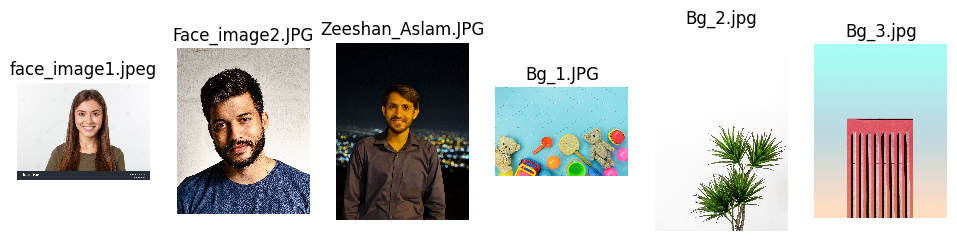

In [33]:
###The captured images are shown as follows###
from google.colab import files
import io
uploaded_files = files.upload()
file_names = list(uploaded_files.keys())
# Create a subplot with one row and five columns

fig, axes = plt.subplots(1, 6, figsize=(12, 8))

for i in range(6):
    # Read image from the uploaded files
    image = Image.open(io.BytesIO(uploaded_files[file_names[i]]))

    # Display the image
    axes[i].imshow(image)
    axes[i].axis('off')  # Turn off axis labels

    # Set the title as the file name
    axes[i].set_title(file_names[i])

plt.show()

###The captured files are displayed as follows##########

In [34]:
def predict_test(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    Arguments:
    parameters -- python dictionary containing your parameters
    X -- input data of size (n_x, m)
    Returns
    predictions -- vector of predictions of our model
    """

    ###############################
    # YOUR CODE STARTS HERE

    # Forward propagation
    AL, _ = L_model_forward(X, parameters)

    # Convert probabilities to binary predictions (0 or 1)
    predictions = (AL > 0.5).astype(int)

    # YOUR CODE ENDS HERE
    ################################

    return predictions

<ipython-input-35-fe29455cf16a>:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"True: {labels[i]}, Predicted: {int(predictions)}")


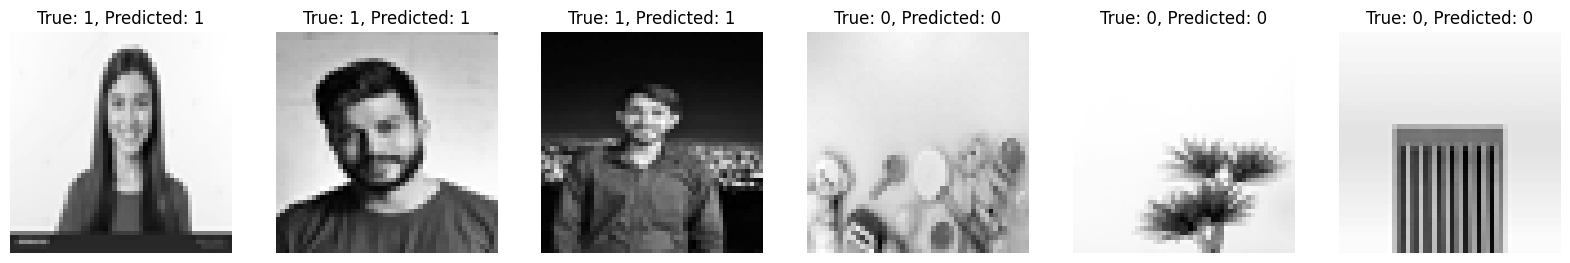

In [35]:
####################################################
# YOUR CODE STARTS HERE

# Load and preprocess your images

face_image1 = Image.open('/content/face_image1.jpeg').convert('L').resize((50, 50))
face_image2 = Image.open('/content/Face_image2.JPG').convert('L').resize((50, 50))
face_image3 = Image.open('/content/Zeeshan_Aslam.JPG').convert('L').resize((50, 50))
background_image1 = Image.open('/content/Bg_1.JPG').convert('L').resize((50, 50))
background_image2 = Image.open('/content/Bg_2.jpg').convert('L').resize((50, 50))
background_image3 = Image.open('/content/Bg_3.jpg').convert('L').resize((50, 50))

# Preprocess images (resize, normalize, flatten, etc.)
# Make sure the preprocessed images match the input size expected by your model

# Preprocess (flatten and normalization) the image to fit the model.
image1 = np.array(face_image1).astype(float) / 255.0
image2 = np.array(face_image2).astype(float) / 255.0
image3 = np.array(face_image3).astype(float) / 255.0
image4 = np.array(background_image1).astype(float) / 255.0
image5 = np.array(background_image2).astype(float) / 255.0
image6 = np.array(background_image3).astype(float) / 255.0


# Display image
#plt.imshow(image)

# Flatten inputs
image1 = image1.reshape((1, 50 * 50)).T
image2 = image2.reshape((1, 50 * 50)).T
image3 = image3.reshape((1, 50 * 50)).T
image4 = image4.reshape((1, 50 * 50)).T
image5 = image5.reshape((1, 50 * 50)).T
image6 = image6.reshape((1, 50 * 50)).T

labels = np.array([1, 1, 1, 0, 0, 0, ])
predictions_all = []

plt.figure(figsize=(20, 3))
# Assuming you have a predict_test function that takes an image as input
for i, image in enumerate([image1, image2, image3, image4, image5, image6]):
    predictions = predict_test(parameters_3, image)
    predictions_all.append(predictions)
    plt.subplot(1, 6, i + 1)  # Increment i to start from 1
    plt.imshow(image.reshape((50, 50, 1)))
    plt.title(f"True: {labels[i]}, Predicted: {int(predictions)}")
    plt.axis('off')

plt.show()


# YOUR CODE ENDS HERE
####################################################


# Congratulations! You have completed homework #2. This was a challenging homework, but it gave you a framework to build any type of network. It was worth the effort. Now you can say: "I built a deep neural network from scratch."